# Measuring spectral properties within fixed apertures

While it is more useful to measure global X-ray properties of galaxy clusters within physically motiviated apertures (i.e. using some scale radius such as $R_{500}$), there are cluster studies which have published results measured within fixed apertures. As such, and because it requires essentially no effort on our part to do, we also measure properties within fixed apertures, to provide a point of comparison to those previous studies if it ever becomes necessary.

<span style="color:red">This should currently be considered preliminary, as there are some problems with observation selection for spectral generation for some of these large clusters - also our improved background method isn't fully implemented</span>

## Import Statements

In [96]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import LambdaCDM
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sources import GalaxyCluster
from xga.sources import BaseSource
from xga.xspec import single_temp_apec, multi_temp_dem_apec
from xga.exceptions import ModelNotAssociatedError

# This is a bit cheeky, but suppresses the warnings that XGA spits out (they are 
#  useful, but not when I'm trying to present this notebook on GitHub)
import warnings
warnings.filterwarnings('ignore')

# Set up a variable that controls how long individual XSPEC fits are allowed to run
timeout = Quantity(6, 'hr')

%matplotlib inline

## Defining the cosmology

We make use of a concordance LambdaCDM model:

In [2]:
cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading in the sample

We need the information from our sample file to declare the XGA ClusterSample further down, primarily the location and redshift, but we also make use of the MCXC estimate of $R_{500}$ to get some idea of the scale of these objects, even if we don't fully trust that measurement:

In [3]:
samp = pd.read_csv('../../sample_files/lovoccs_southnorth.csv')
samp

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes
0,MCXCJ1558.3+2713,J1558.3+2713,0,239.585833,27.226944,0.0894,10.676087,8.1491,1.3803,RXCJ1558.3+2713,A2142,L
1,MCXCJ1510.9+0543,J1510.9+0543,1,227.729167,5.720000,0.0766,8.726709,7.2708,1.3344,A2029,A2029,NaN
2,MCXCJ0258.9+1334,J0258.9+1334,2,44.739583,13.579444,0.0739,6.088643,5.8488,1.2421,RXCJ0258.9+1334,A401,L
3,MCXCJ1348.8+2635,J1348.8+2635,3,207.220833,26.595556,0.0622,5.478067,5.5280,1.2236,RXCJ1348.8+2635,A1795,NaN
4,MCXCJ0041.8-0918,J0041.8-0918,4,10.458750,-9.301944,0.0555,5.100085,5.3163,1.2103,RXCJ0041.8-0918,A85,"L,losStr"
...,...,...,...,...,...,...,...,...,...,...,...,...
139,MCXCJ0448.2-2028,J0448.2-2028,139,72.050833,-20.469722,0.0720,1.004022,1.9513,0.8620,RXCJ0448.2-2028,A514,losStr
140,MCXCJ2323.8+1648,J2323.8+1648,140,350.972917,16.808889,0.0416,1.002026,1.9896,0.8760,A2589,A2589,NaN
141,MCXCJ1416.8-1158,J1416.8-1158,141,214.214583,-11.976111,0.0982,1.001648,1.9133,0.8491,RXCJ1416.8-1158,NaN,X
142,MCXCJ1459.0-0843,J1459.0-0843,142,224.764583,-8.725000,0.1043,1.001337,1.9047,0.8461,RXCJ1459.0-0843,NaN,NaN


<span style="color:red">This is temporary, gives some better starting coordinates for a few of the clusters, which in turn allows them to better select the correct regions - these will eventually be in the sample file</span>

In [4]:
samp.loc[95, 'ra'] = 240.56
samp.loc[95, 'dec'] = 15.965

samp.loc[130, 'ra'] = 359.713
samp.loc[130, 'dec'] = -60.642

samp.loc[89, 'ra'] = 227.865
samp.loc[89, 'dec'] = 6.349

## Setting up an XGA ClusterSample

We set up an XGA ClusterSample object by passing in the information for the entire LoVoCCS sample, as XGA will determine which of the objects actually has XMM data available for itself. We also use the MCXC estimate of $R_{500}$ to 'clean' the observations that have been retrieved for each object, specifying that 10% of the $R_{500}$ region of each cluster must fall on a given observation for that observation to be used; this cleaning threshold is often set higher, but for this population of large, low-redshift, objects we use this smaller fraction to include offset observations of the outskirts. 

In [5]:
ra = samp['ra'].values
dec = samp['dec'].values
z = samp['redshift'].values
r500 = Quantity(samp['R500'].values, 'Mpc')
name = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x)).values

srcs = ClusterSample(ra, dec, z, name, r500=r500, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.1, 
                     use_peak=False, load_fits=True)

Setting up Galaxy Clusters:   0%|          | 0/116 [00:00<?, ?it/s]

ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division
Setting up Galaxy Clusters:  23%|██▎       | 27/116 [01:47<03:07,  2.11s/it]

ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division
Setting up Galaxy Clusters: 100%|██████████| 116/116 [04:53<00:00,  2.53s/it]


This dictionary shows the names of those clusters which are not included in the ClusterSample because they lack data:

In [6]:
srcs.failed_reasons

{'LoVoCCS-18': 'NoMatch',
 'LoVoCCS-24': 'NoMatch',
 'LoVoCCS-37': 'NoMatch',
 'LoVoCCS-53': 'NoMatch',
 'LoVoCCS-54': 'NoMatch',
 'LoVoCCS-61': 'NoMatch',
 'LoVoCCS-72': 'NoMatch',
 'LoVoCCS-87': 'NoMatch',
 'LoVoCCS-91': 'NoMatch',
 'LoVoCCS-93': 'NoMatch',
 'LoVoCCS-98': 'NoMatch',
 'LoVoCCS-99': 'NoMatch',
 'LoVoCCS-102': 'NoMatch',
 'LoVoCCS-105': 'NoMatch',
 'LoVoCCS-106': 'NoMatch',
 'LoVoCCS-108': 'NoMatch',
 'LoVoCCS-109': 'NoMatch',
 'LoVoCCS-110': 'NoMatch',
 'LoVoCCS-111': 'NoMatch',
 'LoVoCCS-112': 'NoMatch',
 'LoVoCCS-113': 'NoMatch',
 'LoVoCCS-119': 'NoMatch',
 'LoVoCCS-122': 'NoMatch',
 'LoVoCCS-126': 'NoMatch',
 'LoVoCCS-133': 'NoMatch',
 'LoVoCCS-137': 'NoMatch',
 'LoVoCCS-141': 'NoMatch',
 'LoVoCCS-142': 'NoMatch'}

In [26]:
srcs.info()


-----------------------------------------------------
Number of Sources - 116
Redshift Information - True
Sources with ≥1 detection - 108 [93%]
-----------------------------------------------------



## Setting up the dataframe to store results

In [76]:
ap_rads = [300, 500, 1000]

### Single-temperature absorbed APEC

In [46]:
cols = ['name'] + [ct.format(ar) for ar in ap_rads for ct in ['Tx_{}kpc', 'Tx_{}kpc-', 'Tx_{}kpc+', 
                                                              'met_{}kpc', 'met_{}kpc-', 'met_{}kpc+', 
                                                              'Lx52_{}kpc', 'Lx52_{}kpc-', 'Lx52_{}kpc+', 
                                                              'Lxbol_{}kpc', 'Lxbol_{}kpc-', 'Lxbol_{}kpc+']]
apec_res = pd.DataFrame(columns=cols)
apec_res['name'] = srcs.names
apec_res

,name,Tx_300kpc,Tx_300kpc-,Tx_300kpc+,met_300kpc,met_300kpc-,met_300kpc+,Lx52_300kpc,Lx52_300kpc-,Lx52_300kpc+,...,Tx_1000kpc+,met_1000kpc,met_1000kpc-,met_1000kpc+,Lx52_1000kpc,Lx52_1000kpc-,Lx52_1000kpc+,Lxbol_1000kpc,Lxbol_1000kpc-,Lxbol_1000kpc+
0,LoVoCCS-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LoVoCCS-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LoVoCCS-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LoVoCCS-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LoVoCCS-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,LoVoCCS-136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,LoVoCCS-138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,LoVoCCS-139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,LoVoCCS-140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Multi-temperature absorbed APEC

In [77]:
cols = ['name'] + [ct.format(ar) for ar in ap_rads for ct in ['Tmax_{}kpc', 'Tmax_{}kpc-', 'Tmax_{}kpc+',
                                                              'beta_{}kpc', 'beta_{}kpc-', 'beta_{}kpc+',
                                                              'invsl_{}kpc', 'invsl_{}kpc-', 'invsl_{}kpc+',
                                                              'met_{}kpc', 'met_{}kpc-', 'met_{}kpc+', 
                                                              'Lx52_{}kpc', 'Lx52_{}kpc-', 'Lx52_{}kpc+', 
                                                              'Lxbol_{}kpc', 'Lxbol_{}kpc-', 'Lxbol_{}kpc+']]
wdem_res = pd.DataFrame(columns=cols)
wdem_res['name'] = srcs.names
wdem_res

,name,Tmax_300kpc,Tmax_300kpc-,Tmax_300kpc+,beta_300kpc,beta_300kpc-,beta_300kpc+,invsl_300kpc,invsl_300kpc-,invsl_300kpc+,...,invsl_1000kpc+,met_1000kpc,met_1000kpc-,met_1000kpc+,Lx52_1000kpc,Lx52_1000kpc-,Lx52_1000kpc+,Lxbol_1000kpc,Lxbol_1000kpc-,Lxbol_1000kpc+
0,LoVoCCS-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LoVoCCS-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LoVoCCS-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LoVoCCS-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LoVoCCS-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,LoVoCCS-136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,LoVoCCS-138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,LoVoCCS-139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,LoVoCCS-140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Generating and fitting spectra within fixed apertures

We use XGA to generate spectra within different fixed apertures, and then we fit two models to them to extract temperature, abundance, and luminosity information. The first model is a standard absorbed APEC plasma model, and the second is an absorbed multi-temperature APEC model (wdem):

### $R_{\rm{out}}=300\:\rm{kpc}$ & $R^{\rm{back}}_{\rm{inn}}=1000\:\rm{kpc}$ & $R^{\rm{back}}_{\rm{out}}=1500\:\rm{kpc}$

<span style="color:red">This is temporary, XGA will support both setting the background annulus at spectrum generation time, **and** entirely different background methods very soon</span>

In [8]:
for src in srcs:
    src._back_inn_factor = 3.33
    src._back_out_factor = 5

<span style="color:red">Also temporary - need to disassociate observations that cause spectrum generation problems - this will be handled in a more sophisticated way soon</span>

In [9]:
errors = """[[SASGenerationError(' raised by  - - LoVoCCS-0 is the associated source, the specific data used is 0694440601-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440601_mos1_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440601-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440601_mos1_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440601-mos1."), SASGenerationError(' raised by  - - LoVoCCS-0 is the associated source, the specific data used is 0694440601-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440601_mos2_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440601-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440601_mos2_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440601-mos2."), SASGenerationError(' raised by  - - LoVoCCS-0 is the associated source, the specific data used is 0694440601-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440601_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440601-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440601_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440601-pn."), SASGenerationError(' raised by  - - LoVoCCS-0 is the associated source, the specific data used is 0694440101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440101_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440101_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.04992873231970208_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440101-pn.")], [SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =-21000, max =-22800 ) is invalid.- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos1.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =-21000, max =-22800 ) is invalid.- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos1.'), SASGenerationError('MapXRangeInvalid raised by arfgen - X range for map ( min =22678.17028, max =21038.17028 ) is invalid.- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos2.'), SASGenerationError('MapXRangeInvalid raised by backscale - X range for map ( min =22678.17028, max =21008.17028 ) is invalid.- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos2.'), SASGenerationError('MapXRangeInvalid raised by arfgen - X range for map ( min =-21000, max =-22440 ) is invalid.- LoVoCCS-1 is the associated source, the specific data used is 0744411201-pn.'), SASGenerationError('MapXRangeInvalid raised by backscale - X range for map ( min =-21000, max =-22450 ) is invalid.- LoVoCCS-1 is the associated source, the specific data used is 0744411201-pn.'), SASGenerationError(' raised by  - - LoVoCCS-1 is the associated source, the specific data used is 0744411101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0744411101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0744411101-pn."), SASGenerationError(' raised by  - - LoVoCCS-1 is the associated source, the specific data used is 0744411001-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0744411001-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0744411001-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190201-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190201_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190201-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190201_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190201-mos1."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190101-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190101_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190101-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190101_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190101-mos1."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0112260201-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0112260201_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260201-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0112260201_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260201-mos1."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190301-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190301_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190301-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190301_mos1_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190301-mos1."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0112260201-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0112260201_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260201-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0112260201_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260201-mos2."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190301-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190301_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190301-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190301_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190301-mos2."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190201-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190201_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190201-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190201_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190201-mos2."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190101-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190101_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190101-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190101_mos2_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190101-mos2."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0112260201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0112260201_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0112260201_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260201-pn."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190301_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190301_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190301-pn."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190101_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190101_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190101-pn."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0881190201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0881190201_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0881190201_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0881190201-pn."), SASGenerationError(' raised by  - - LoVoCCS-2 is the associated source, the specific data used is 0112260401-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0112260401_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260401-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0112260401_pn_LoVoCCS-2_ra44.73958333_dec13.57944444_ri0.0_ro0.059323933896012766_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-2 is the associated source, the specific data used is 0112260401-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0205190201-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0205190201_mos2_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190201-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0205190201_mos2_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190201-mos2."), SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0205190201-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0205190201_mos1_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190201-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0205190201_mos1_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190201-mos1."), SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0744412001-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744412001_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412001-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744412001_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412001-pn."), SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0205190201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0205190201_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0205190201_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190201-pn."), SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0205190101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0205190101_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0205190101_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.06952404295116549_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0205190101-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-4 is the associated source, the specific data used is 0744411701-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.0773046479816188_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-4 is the associated source, the specific data used is 0744411701-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.0773046479816188_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-4 is the associated source, the specific data used is 0744411701-pn."), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =-21000, max =-21600 ) is invalid.- LoVoCCS-4 is the associated source, the specific data used is 0065140201-pn.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =-21000, max =-21630 ) is invalid.- LoVoCCS-4 is the associated source, the specific data used is 0065140201-pn.'), SASGenerationError('MapXRangeInvalid raised by arfgen - X range for map ( min =21700.78381, max =21020.78381 ) is invalid.- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos1.'), SASGenerationError('MapXRangeInvalid raised by backscale - X range for map ( min =21700.78381, max =21000.78381 ) is invalid.- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos1.'), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =21483.75653, max =21003.75653 ) is invalid.- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos2.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =21483.75653, max =21003.75653 ) is invalid.- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos2.')], [SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =-21000, max =-27520 ) is invalid.- LoVoCCS-10 is the associated source, the specific data used is 0821270601-mos2.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =-21000, max =-27520 ) is invalid.- LoVoCCS-10 is the associated source, the specific data used is 0821270601-mos2.'), SASGenerationError(' raised by  - - LoVoCCS-10 is the associated source, the specific data used is 0844050301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.07903740627438989_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0844050301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.07903740627438989_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0844050301-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-20 is the associated source, the specific data used is 0744930201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744930201_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0744930201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744930201_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0744930201-pn."), SASGenerationError(' raised by  - - LoVoCCS-20 is the associated source, the specific data used is 0601980301-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0601980301_mos2_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980301-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0601980301_mos2_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980301-mos2."), SASGenerationError(' raised by  - - LoVoCCS-20 is the associated source, the specific data used is 0601980301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0601980301_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0601980301_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980301-pn."), SASGenerationError(' raised by  - - LoVoCCS-20 is the associated source, the specific data used is 0601980301-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0601980301_mos1_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980301-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0601980301_mos1_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980301-mos1."), SASGenerationError(' raised by  - - LoVoCCS-20 is the associated source, the specific data used is 0601980101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0601980101_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0601980101_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0601980101-pn."), SASGenerationError(' raised by  - - LoVoCCS-20 is the associated source, the specific data used is 0651590201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0651590201_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0651590201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0651590201_pn_LoVoCCS-20_ra201.9895833_dec-31.5025_ri0.0_ro0.08859387348271884_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-20 is the associated source, the specific data used is 0651590201-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-22 is the associated source, the specific data used is 0744410701-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744410701_pn_LoVoCCS-22_ra258.1966667_dec64.06138889_ri0.0_ro0.05463412948342903_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-22 is the associated source, the specific data used is 0744410701-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744410701_pn_LoVoCCS-22_ra258.1966667_dec64.06138889_ri0.0_ro0.05463412948342903_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-22 is the associated source, the specific data used is 0744410701-pn."), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =-21000, max =-22000 ) is invalid.- LoVoCCS-22 is the associated source, the specific data used is 0744410501-pn.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =-21000, max =-22000 ) is invalid.- LoVoCCS-22 is the associated source, the specific data used is 0744410501-pn.'), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =21816.72875, max =21016.72875 ) is invalid.- LoVoCCS-22 is the associated source, the specific data used is 0744410501-mos2.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =21816.72875, max =21006.72875 ) is invalid.- LoVoCCS-22 is the associated source, the specific data used is 0744410501-mos2.')], [SASGenerationError('MapXRangeInvalid raised by arfgen - X range for map ( min =21558.08867, max =21038.08867 ) is invalid.- LoVoCCS-26 is the associated source, the specific data used is 0744411301-pn.'), SASGenerationError('MapXRangeInvalid raised by backscale - X range for map ( min =21558.08867, max =21008.08867 ) is invalid.- LoVoCCS-26 is the associated source, the specific data used is 0744411301-pn.'), SASGenerationError(' raised by  - - LoVoCCS-26 is the associated source, the specific data used is 0744411501-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744411501_pn_LoVoCCS-26_ra55.72458333_dec-53.63527778_ri0.0_ro0.07301944895499086_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-26 is the associated source, the specific data used is 0744411501-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744411501_pn_LoVoCCS-26_ra55.72458333_dec-53.63527778_ri0.0_ro0.07301944895499086_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-26 is the associated source, the specific data used is 0744411501-pn."), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =21266.9145, max =21026.9145 ) is invalid.- LoVoCCS-26 is the associated source, the specific data used is 0744411301-mos1.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =21266.9145, max =21006.9145 ) is invalid.- LoVoCCS-26 is the associated source, the specific data used is 0744411301-mos1.'), SASGenerationError('MapXRangeInvalid raised by arfgen - X range for map ( min =-21000, max =-21440 ) is invalid.- LoVoCCS-26 is the associated source, the specific data used is 0744411301-mos2.'), SASGenerationError('MapXRangeInvalid raised by backscale - X range for map ( min =-21000, max =-21470 ) is invalid.- LoVoCCS-26 is the associated source, the specific data used is 0744411301-mos2.')], [SASGenerationError(' raised by  - - LoVoCCS-27 is the associated source, the specific data used is 0744413101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413101_pn_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413101_pn_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413101-pn."), SASGenerationError(' raised by  - - LoVoCCS-27 is the associated source, the specific data used is 0744413301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413301_pn_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413301_pn_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413301-pn."), SASGenerationError(' raised by  - - LoVoCCS-27 is the associated source, the specific data used is 0744413401-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413401_pn_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413401-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413401_pn_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.05741325687211263_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413401-pn."), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =-21000, max =-22760 ) is invalid.- LoVoCCS-27 is the associated source, the specific data used is 0744413201-mos1.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =-21000, max =-22760 ) is invalid.- LoVoCCS-27 is the associated source, the specific data used is 0744413201-mos1.'), SASGenerationError('MapXRangeInvalid raised by arfgen - X range for map ( min =-21000, max =-22400 ) is invalid.- LoVoCCS-27 is the associated source, the specific data used is 0744413201-pn.'), SASGenerationError('MapXRangeInvalid raised by backscale - X range for map ( min =-21000, max =-22410 ) is invalid.- LoVoCCS-27 is the associated source, the specific data used is 0744413201-pn.'), SASGenerationError('MapXRangeInvalid raised by arfgen - X range for map ( min =22631.50643, max =21031.50643 ) is invalid.- LoVoCCS-27 is the associated source, the specific data used is 0744413201-mos2.'), SASGenerationError('MapXRangeInvalid raised by backscale - X range for map ( min =22631.50643, max =21001.50643 ) is invalid.- LoVoCCS-27 is the associated source, the specific data used is 0744413201-mos2.')], [SASGenerationError(' raised by  - - LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos1."), SASGenerationError(' raised by  - - LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos2."), SASGenerationError(' raised by  - - LoVoCCS-29 is the associated source, the specific data used is 0725240101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0725240101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0725240101-pn."), SASGenerationError(' raised by  - - LoVoCCS-29 is the associated source, the specific data used is 0694440801-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440801-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440801-pn."), SASGenerationError(' raised by  - - LoVoCCS-29 is the associated source, the specific data used is 0694440701-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440701-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440701-pn."), SASGenerationError(' raised by  - - LoVoCCS-29 is the associated source, the specific data used is 0694440301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.07944915548356747_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-29 is the associated source, the specific data used is 0694440301-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-46 is the associated source, the specific data used is 0784521301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.1391858441604247_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-46 is the associated source, the specific data used is 0784521301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.1391858441604247_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-46 is the associated source, the specific data used is 0784521301-pn."), SASGenerationError(' raised by  - - LoVoCCS-46 is the associated source, the specific data used is 0784521201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.1391858441604247_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-46 is the associated source, the specific data used is 0784521201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.1391858441604247_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-46 is the associated source, the specific data used is 0784521201-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-47 is the associated source, the specific data used is 0744412901-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744412901_pn_LoVoCCS-47_ra194.2904167_dec-17.40027778_ri0.0_ro0.0898303620464355_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-47 is the associated source, the specific data used is 0744412901-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744412901_pn_LoVoCCS-47_ra194.2904167_dec-17.40027778_ri0.0_ro0.0898303620464355_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-47 is the associated source, the specific data used is 0744412901-pn."), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =21180.73978, max =21020.73978 ) is invalid.- LoVoCCS-47 is the associated source, the specific data used is 0744412701-mos2.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =21180.73978, max =21000.73978 ) is invalid.- LoVoCCS-47 is the associated source, the specific data used is 0744412701-mos2.'), SASGenerationError('MapYRangeInvalid raised by arfgen - Y range for map ( min =-21000, max =-21280 ) is invalid.- LoVoCCS-47 is the associated source, the specific data used is 0744412701-pn.'), SASGenerationError('MapYRangeInvalid raised by backscale - Y range for map ( min =-21000, max =-21280 ) is invalid.- LoVoCCS-47 is the associated source, the specific data used is 0744412701-pn.')], [SASGenerationError(' raised by  - - LoVoCCS-63 is the associated source, the specific data used is 0674491301-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0674491301_mos1_LoVoCCS-63_ra325.9929167_dec-56.62638889_ri0.0_ro0.0537330498341645_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-63 is the associated source, the specific data used is 0674491301-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0674491301_mos1_LoVoCCS-63_ra325.9929167_dec-56.62638889_ri0.0_ro0.0537330498341645_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-63 is the associated source, the specific data used is 0674491301-mos1."), SASGenerationError(' raised by  - - LoVoCCS-63 is the associated source, the specific data used is 0674491301-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0674491301_mos2_LoVoCCS-63_ra325.9929167_dec-56.62638889_ri0.0_ro0.0537330498341645_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-63 is the associated source, the specific data used is 0674491301-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0674491301_mos2_LoVoCCS-63_ra325.9929167_dec-56.62638889_ri0.0_ro0.0537330498341645_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-63 is the associated source, the specific data used is 0674491301-mos2.")], [SASGenerationError(' raised by  - - LoVoCCS-75 is the associated source, the specific data used is 0783380152-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0783380152_pn_LoVoCCS-75_ra348.25375_dec-21.63194444_ri0.0_ro0.05111110125393099_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-75 is the associated source, the specific data used is 0783380152-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0783380152_pn_LoVoCCS-75_ra348.25375_dec-21.63194444_ri0.0_ro0.05111110125393099_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-75 is the associated source, the specific data used is 0783380152-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-97 is the associated source, the specific data used is 0861150301-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0861150301_mos2_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.07743504703057509_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0861150301-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0861150301_mos2_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.07743504703057509_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0861150301-mos2."), SASGenerationError(' raised by  - - LoVoCCS-97 is the associated source, the specific data used is 0861150301-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0861150301_mos1_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.07743504703057509_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0861150301-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0861150301_mos1_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.07743504703057509_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0861150301-mos1."), SASGenerationError(' raised by  - - LoVoCCS-97 is the associated source, the specific data used is 0861150301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0861150301_pn_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.07743504703057509_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0861150301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0861150301_pn_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.07743504703057509_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0861150301-pn.")]]"""

to_dis = {}
for err in errors.split('SASGenerationError('):
    name = err.split(' is the associated source,')[0].split('- ')[-1]
    
    if 'LoVoCCS' in name:
        if name not in to_dis:
            to_dis[name] = {}
        obs_id, inst = err.split('the specific data used is ')[-1].split(".")[0].split('-')
        if obs_id in to_dis[name]:
            to_dis[name][obs_id].append(inst)
        else:
            to_dis[name][obs_id] = [inst]

for name in to_dis:
    for oi in to_dis[name]:
        to_dis[name][oi] = list(set(to_dis[name][oi]))
    srcs[name].disassociate_obs(to_dis[name])
to_dis

{'LoVoCCS-0': {'0694440601': ['mos1', 'pn', 'mos2'], '0694440101': ['pn']},
 'LoVoCCS-1': {'0744411201': ['mos1', 'pn', 'mos2'],
  '0744411101': ['pn'],
  '0744411001': ['pn']},
 'LoVoCCS-2': {'0881190201': ['mos1', 'pn', 'mos2'],
  '0881190101': ['mos1', 'pn', 'mos2'],
  '0112260201': ['mos1', 'pn', 'mos2'],
  '0881190301': ['mos1', 'pn', 'mos2'],
  '0112260401': ['pn']},
 'LoVoCCS-3': {'0205190201': ['mos2', 'pn', 'mos1'],
  '0744412001': ['pn'],
  '0205190101': ['pn']},
 'LoVoCCS-4': {'0744411701': ['pn'], '0065140201': ['pn', 'mos2', 'mos1']},
 'LoVoCCS-10': {'0821270601': ['mos2'], '0844050301': ['pn']},
 'LoVoCCS-20': {'0744930201': ['pn'],
  '0601980301': ['mos2', 'pn', 'mos1'],
  '0601980101': ['pn'],
  '0651590201': ['pn']},
 'LoVoCCS-22': {'0744410701': ['pn'], '0744410501': ['pn', 'mos2']},
 'LoVoCCS-26': {'0744411301': ['pn', 'mos2', 'mos1'], '0744411501': ['pn']},
 'LoVoCCS-27': {'0744413101': ['pn'],
  '0744413301': ['pn'],
  '0744413401': ['pn'],
  '0744413201': ['mos1',

#### Single-temperature absorbed APEC model

In [10]:
single_temp_apec(srcs, Quantity(300, 'kpc'), freeze_met=False, one_rmf=False, timeout=timeout)

Running XSPEC Fits: 100%|██████████| 35/35 [00:48<00:00,  1.38s/it]


This is a quick way to check how many successful fits with this model to this aperture's spectra there were:

In [11]:
print(len(np.where(~np.isnan(srcs.Tx(Quantity(300, 'kpc'), quality_checks=False)[:, 0]))[0]))

81


Here we implement a very inelegant way of storing the properties measured using this model for this aperture in the Pandas dataframes set up earlier in the notebook, those will then be saved to disk:

In [78]:
for src in srcs:
    rel_res_ind = np.where(apec_res['name'].values == src.name)[0][0]
    try:
        txs = src.get_temperature(Quantity(300, 'kpc'))
        apec_res.loc[rel_res_ind, ['Tx_300kpc', 'Tx_300kpc-', 'Tx_300kpc+']] = txs.value
        
        mets = src.get_results(Quantity(300, 'kpc'), par='Abundanc')
        apec_res.loc[rel_res_ind, ['met_300kpc', 'met_300kpc-', 'met_300kpc+']] = mets
        
        lx52s = src.get_luminosities(Quantity(300, 'kpc'), lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
        apec_res.loc[rel_res_ind, ['Lx52_300kpc', 'Lx52_300kpc-', 'Lx52_300kpc+']] = lx52s.to('10^44 erg/s').value
        
        lxbols = src.get_luminosities(Quantity(300, 'kpc'), lo_en=Quantity(0.01, 'keV'), hi_en=Quantity(100.0, 'keV'))
        apec_res.loc[rel_res_ind, ['Lxbol_300kpc', 'Lxbol_300kpc-', 'Lxbol_300kpc+']] = lxbols.to('10^44 erg/s').value
    except ModelNotAssociatedError:
        pass

#### Multi-temperature absorbed APEC model

In [45]:
multi_temp_dem_apec(srcs, Quantity(300, 'kpc'), start_max_temp=Quantity(10, 'keV'), freeze_met=False, one_rmf=False, 
                    timeout=Quantity(2, 'hr'))

Running XSPEC Fits: 100%|██████████| 116/116 [2:18:23<00:00, 71.58s/it]  


In [89]:
for src in srcs:
    rel_res_ind = np.where(wdem_res['name'].values == src.name)[0][0]
    try:
        mtxs = src.get_results(Quantity(300, 'kpc'), 'constant*tbabs*wdem', par='Tmax')
        wdem_res.loc[rel_res_ind, ['Tmax_300kpc', 'Tmax_300kpc-', 'Tmax_300kpc+']] = mtxs
        
        betas = src.get_results(Quantity(300, 'kpc'), 'constant*tbabs*wdem', par='beta')
        wdem_res.loc[rel_res_ind, ['beta_300kpc', 'beta_300kpc-', 'beta_300kpc+']] = betas
        
        inv_sls = src.get_results(Quantity(300, 'kpc'), 'constant*tbabs*wdem', par='inv_slope')
        wdem_res.loc[rel_res_ind, ['invsl_300kpc', 'invsl_300kpc-', 'invsl_300kpc+']] = inv_sls
        
        mets = src.get_results(Quantity(300, 'kpc'), 'constant*tbabs*wdem', par='abundanc')
        wdem_res.loc[rel_res_ind, ['met_300kpc', 'met_300kpc-', 'met_300kpc+']] = mets
        
        lx52s = src.get_luminosities(Quantity(300, 'kpc'), 'constant*tbabs*wdem', lo_en=Quantity(0.5, 'keV'), 
                                     hi_en=Quantity(2.0, 'keV'))
        wdem_res.loc[rel_res_ind, ['Lx52_300kpc', 'Lx52_300kpc-', 'Lx52_300kpc+']] = lx52s.to('10^44 erg/s').value
        
        lxbols = src.get_luminosities(Quantity(300, 'kpc'), 'constant*tbabs*wdem', lo_en=Quantity(0.01, 'keV'), 
                                      hi_en=Quantity(100.0, 'keV'))
        wdem_res.loc[rel_res_ind, ['Lxbol_300kpc', 'Lxbol_300kpc-', 'Lxbol_300kpc+']] = lxbols.to('10^44 erg/s').value
    except ModelNotAssociatedError:
        pass

### $R_{\rm{out}}=500\:\rm{kpc}$ & $R^{\rm{back}}_{\rm{inn}}=1000\:\rm{kpc}$ & $R^{\rm{back}}_{\rm{out}}=1500\:\rm{kpc}$

<span style="color:red">This is temporary, XGA will support both setting the background annulus at spectrum generation time, **and** entirely different background methods very soon</span>

In [90]:
for src in srcs:
    src._back_inn_factor = 2
    src._back_out_factor = 3

<span style="color:red">Also temporary - need to disassociate observations that cause spectrum generation problems - this will be handled in a more sophisticated way soon</span>

In [91]:
errors = """[[SASGenerationError(' raised by  - - LoVoCCS-0 is the associated source, the specific data used is 0112240401-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0112240401_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.08321455386617013_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0112240401-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0112240401_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.08321455386617013_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0112240401-pn."), SASGenerationError(' raised by  - - LoVoCCS-0 is the associated source, the specific data used is 0694440201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0694440201_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.08321455386617013_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0694440201_pn_LoVoCCS-0_ra239.5858333_dec27.22694444_ri0.0_ro0.08321455386617013_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-0 is the associated source, the specific data used is 0694440201-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-1 is the associated source, the specific data used is 0822350101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0822350101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0822350101-pn."), SASGenerationError(' raised by  - - LoVoCCS-1 is the associated source, the specific data used is 0744410901-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0744410901-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0744410901-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0744412001-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744412001_mos1_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.11587340491860917_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412001-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744412001_mos1_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.11587340491860917_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412001-mos1."), SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0744412001-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744412001_mos2_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.11587340491860917_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412001-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744412001_mos2_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.11587340491860917_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412001-mos2."), SASGenerationError(' raised by  - - LoVoCCS-3 is the associated source, the specific data used is 0744412101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744412101_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.11587340491860917_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744412101_pn_LoVoCCS-3_ra207.2208333_dec26.59555556_ri0.0_ro0.11587340491860917_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-3 is the associated source, the specific data used is 0744412101-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-4 is the associated source, the specific data used is 0744411901-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.1288410799693647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-4 is the associated source, the specific data used is 0744411901-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.1288410799693647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-4 is the associated source, the specific data used is 0744411901-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-10 is the associated source, the specific data used is 0844050101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.13172901045731647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0844050101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.13172901045731647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0844050101-pn."), SASGenerationError(' raised by  - - LoVoCCS-10 is the associated source, the specific data used is 0844050401-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.13172901045731647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0844050401-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.13172901045731647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0844050401-pn."), SASGenerationError(' raised by  - - LoVoCCS-10 is the associated source, the specific data used is 0556200301-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.13172901045731647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0556200301-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.13172901045731647_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-10 is the associated source, the specific data used is 0556200301-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-27 is the associated source, the specific data used is 0744413101-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413101_mos2_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413101-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413101_mos2_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413101-mos2."), SASGenerationError(' raised by  - - LoVoCCS-27 is the associated source, the specific data used is 0744413401-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413401_mos1_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413401-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413401_mos1_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413401-mos1."), SASGenerationError(' raised by  - - LoVoCCS-27 is the associated source, the specific data used is 0744413301-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413301_mos2_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413301-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413301_mos2_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413301-mos2."), SASGenerationError(' raised by  - - LoVoCCS-27 is the associated source, the specific data used is 0744413401-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413401_mos2_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413401-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413401_mos2_LoVoCCS-27_ra184.4191667_dec3.6625_ri0.0_ro0.09568876145352104_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-27 is the associated source, the specific data used is 0744413401-mos2.")], [SASGenerationError(' raised by  - - LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.23197640693404115_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.23197640693404115_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos1.")], [SASGenerationError(' raised by  - - LoVoCCS-47 is the associated source, the specific data used is 0744413001-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0744413001_pn_LoVoCCS-47_ra194.2904167_dec-17.40027778_ri0.0_ro0.14971727007739252_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-47 is the associated source, the specific data used is 0744413001-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0744413001_pn_LoVoCCS-47_ra194.2904167_dec-17.40027778_ri0.0_ro0.14971727007739252_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-47 is the associated source, the specific data used is 0744413001-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-97 is the associated source, the specific data used is 0201780101-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0201780101_pn_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.12905841171762517_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0201780101-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0201780101_pn_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.12905841171762517_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0201780101-pn."), SASGenerationError(' raised by  - - LoVoCCS-97 is the associated source, the specific data used is 0030140201-pn.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0030140201_pn_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.12905841171762517_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0030140201-pn."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0030140201_pn_LoVoCCS-97_ra194.3204167_dec-30.37694444_ri0.0_ro0.12905841171762517_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-97 is the associated source, the specific data used is 0030140201-pn.")], [SASGenerationError(' raised by  - - LoVoCCS-120 is the associated source, the specific data used is 0821310101-mos1.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0821310101_mos1_LoVoCCS-120_ra193.6725_dec-29.22333333_ri0.0_ro0.13127572042194044_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-120 is the associated source, the specific data used is 0821310101-mos1."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0821310101_mos1_LoVoCCS-120_ra193.6725_dec-29.22333333_ri0.0_ro0.13127572042194044_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-120 is the associated source, the specific data used is 0821310101-mos1."), SASGenerationError(' raised by  - - LoVoCCS-120 is the associated source, the specific data used is 0821310101-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0821310101_mos2_LoVoCCS-120_ra193.6725_dec-29.22333333_ri0.0_ro0.13127572042194044_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-120 is the associated source, the specific data used is 0821310101-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0821310101_mos2_LoVoCCS-120_ra193.6725_dec-29.22333333_ri0.0_ro0.13127572042194044_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-120 is the associated source, the specific data used is 0821310101-mos2.")]]"""

to_dis = {}
for err in errors.split('SASGenerationError('):
    name = err.split(' is the associated source,')[0].split('- ')[-1]
    
    if 'LoVoCCS' in name:
        if name not in to_dis:
            to_dis[name] = {}
        obs_id, inst = err.split('the specific data used is ')[-1].split(".")[0].split('-')
        if obs_id in to_dis[name]:
            to_dis[name][obs_id].append(inst)
        else:
            to_dis[name][obs_id] = [inst]

for name in to_dis:
    for oi in to_dis[name]:
        to_dis[name][oi] = list(set(to_dis[name][oi]))
    srcs[name].disassociate_obs(to_dis[name])
to_dis

{'LoVoCCS-0': {'0112240401': ['pn'], '0694440201': ['pn']},
 'LoVoCCS-1': {'0822350101': ['pn'], '0744410901': ['pn']},
 'LoVoCCS-3': {'0744412001': ['mos1', 'mos2'], '0744412101': ['pn']},
 'LoVoCCS-4': {'0744411901': ['pn']},
 'LoVoCCS-10': {'0844050101': ['pn'],
  '0844050401': ['pn'],
  '0556200301': ['pn']},
 'LoVoCCS-27': {'0744413101': ['mos2'],
  '0744413401': ['mos1', 'mos2'],
  '0744413301': ['mos2']},
 'LoVoCCS-46': {'0784521301': ['mos1']},
 'LoVoCCS-47': {'0744413001': ['pn']},
 'LoVoCCS-97': {'0201780101': ['pn'], '0030140201': ['pn']},
 'LoVoCCS-120': {'0821310101': ['mos1', 'mos2']}}

#### Single-temperature absorbed APEC model

In [92]:
single_temp_apec(srcs, Quantity(500, 'kpc'), freeze_met=False, one_rmf=False, timeout=timeout)

Running XSPEC Fits: 100%|██████████| 30/30 [03:43<00:00,  7.45s/it]


In [93]:
print(len(np.where(~np.isnan(srcs.Tx(Quantity(500, 'kpc'), quality_checks=False)[:, 0]))[0]))

86


In [94]:
for src in srcs:
    rel_res_ind = np.where(apec_res['name'].values == src.name)[0][0]
    try:
        txs = src.get_temperature(Quantity(500, 'kpc'))
        apec_res.loc[rel_res_ind, ['Tx_500kpc', 'Tx_500kpc-', 'Tx_500kpc+']] = txs.value
        
        mets = src.get_results(Quantity(500, 'kpc'), par='Abundanc')
        apec_res.loc[rel_res_ind, ['met_500kpc', 'met_500kpc-', 'met_500kpc+']] = mets
        
        lx52s = src.get_luminosities(Quantity(500, 'kpc'), lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
        apec_res.loc[rel_res_ind, ['Lx52_500kpc', 'Lx52_500kpc-', 'Lx52_500kpc+']] = lx52s.to('10^44 erg/s').value
        
        lxbols = src.get_luminosities(Quantity(500, 'kpc'), lo_en=Quantity(0.01, 'keV'), hi_en=Quantity(100.0, 'keV'))
        apec_res.loc[rel_res_ind, ['Lxbol_500kpc', 'Lxbol_500kpc-', 'Lxbol_500kpc+']] = lxbols.to('10^44 erg/s').value
    except ModelNotAssociatedError:
        pass

#### Multi-temperature absorbed-APEC model

In [98]:
multi_temp_dem_apec(srcs, Quantity(500, 'kpc'), start_max_temp=Quantity(10, 'keV'), freeze_met=False, one_rmf=False, 
                    timeout=Quantity(2, 'hr'))

Running XSPEC Fits: 100%|██████████| 116/116 [2:32:31<00:00, 78.89s/it]  


LoVoCCS-23


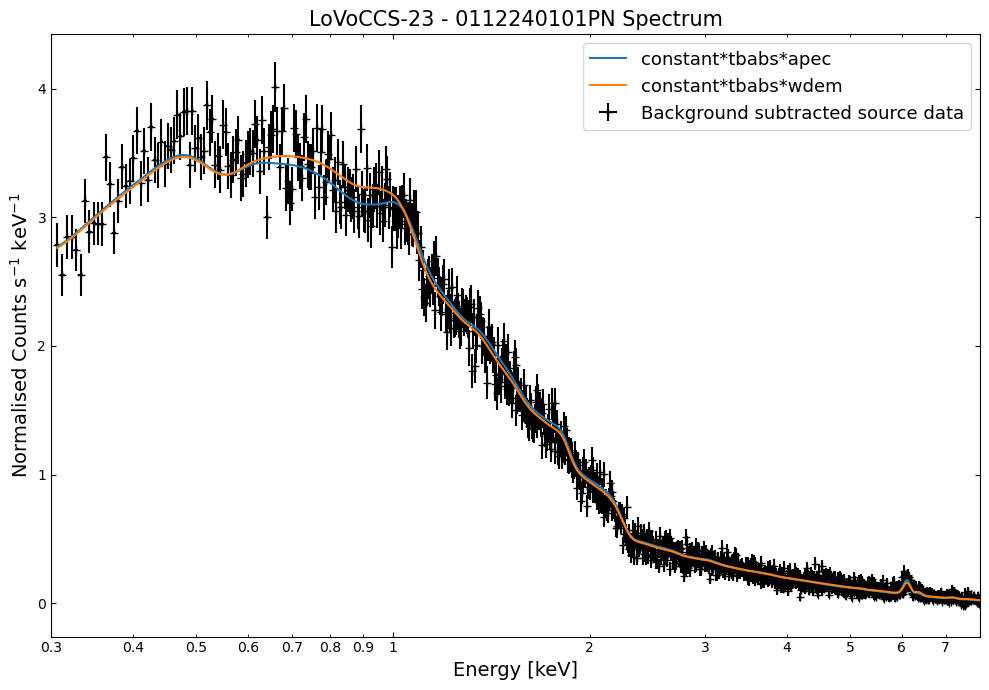

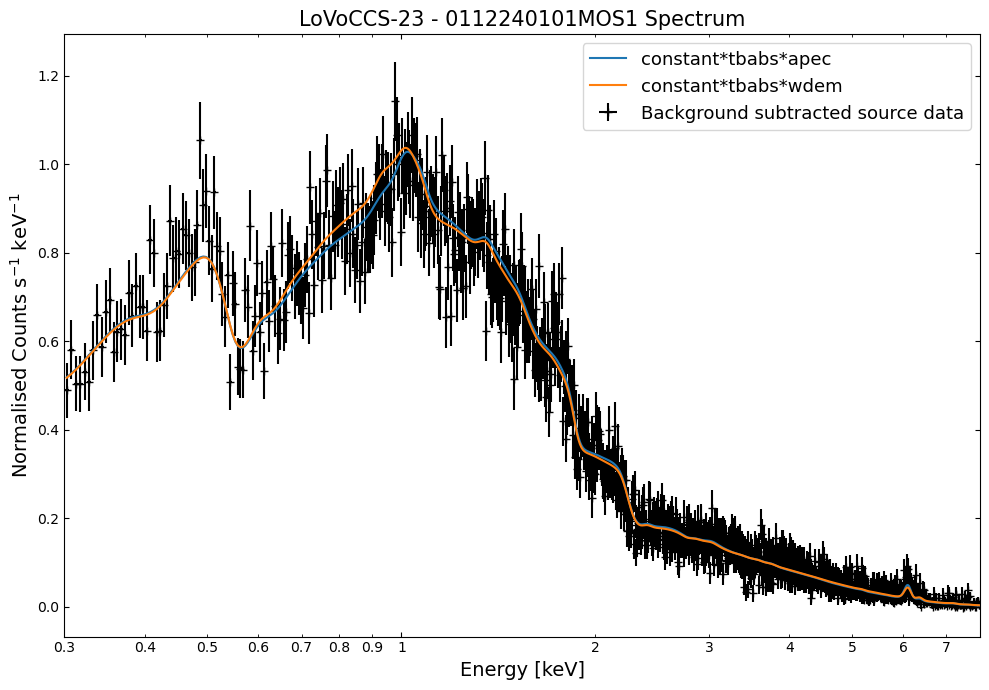

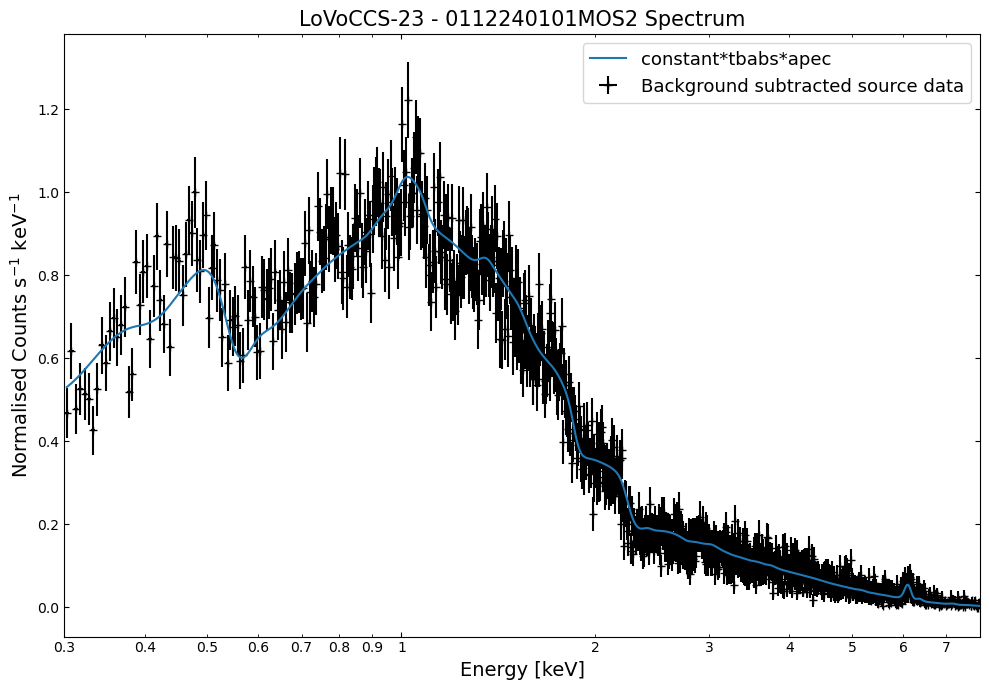

LoVoCCS-25


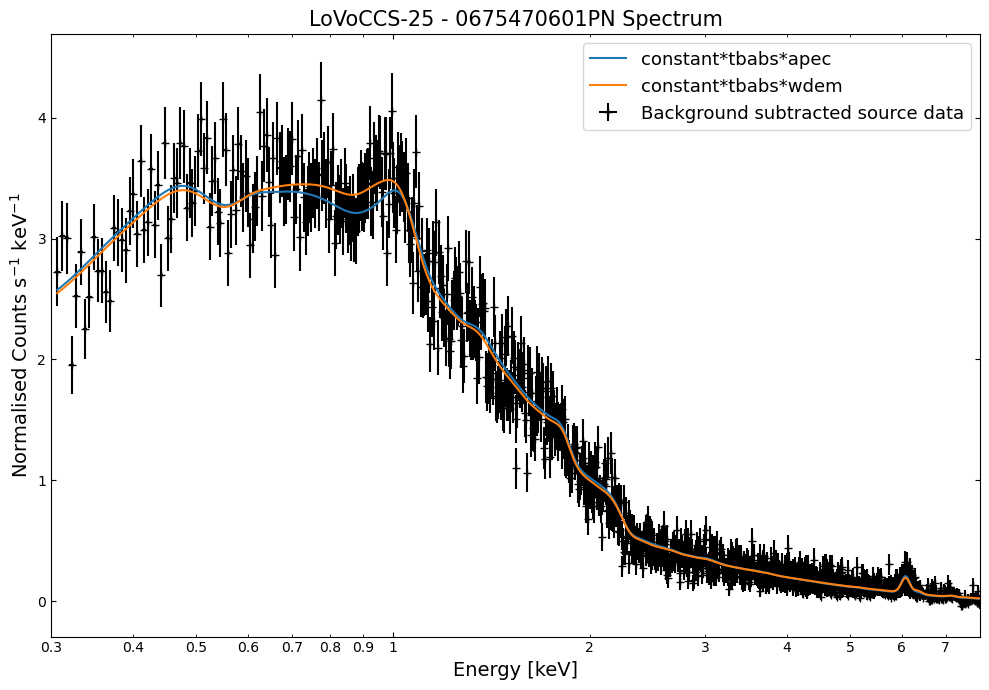

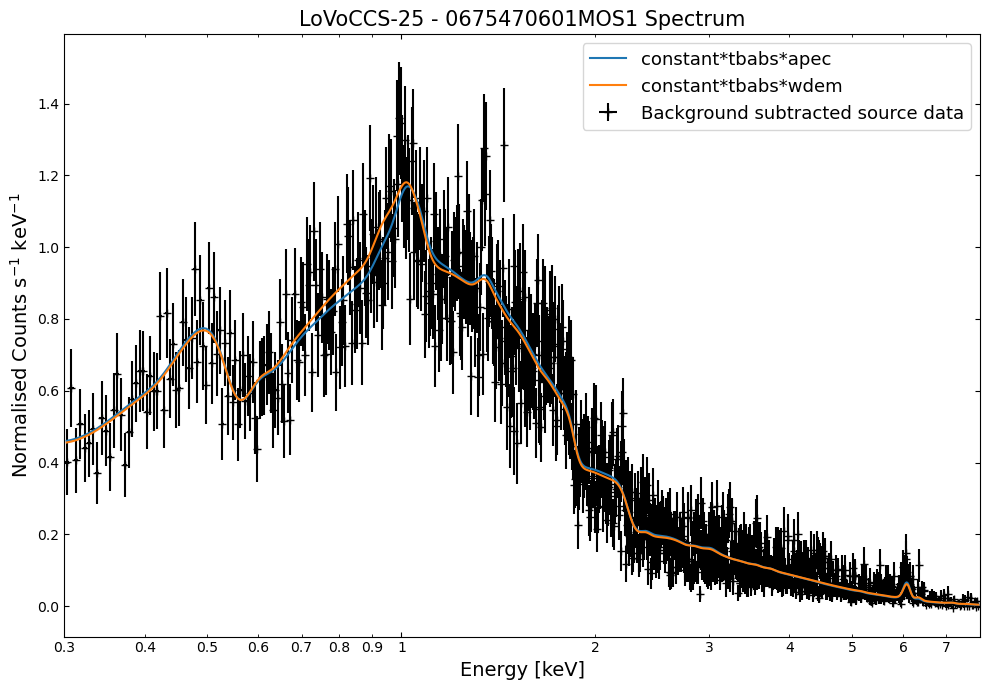

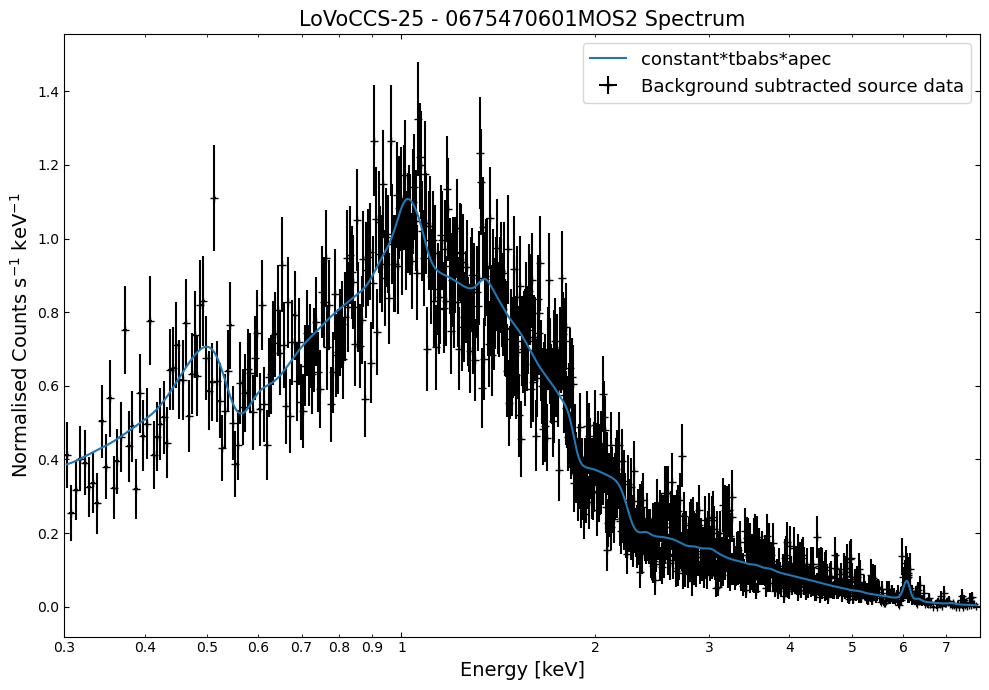

LoVoCCS-103


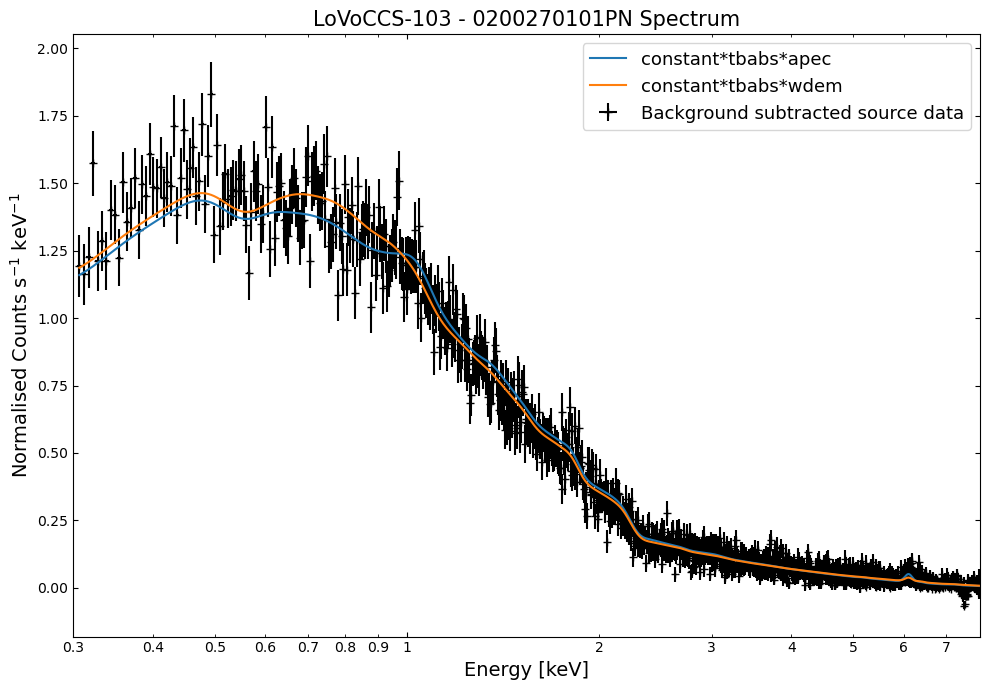

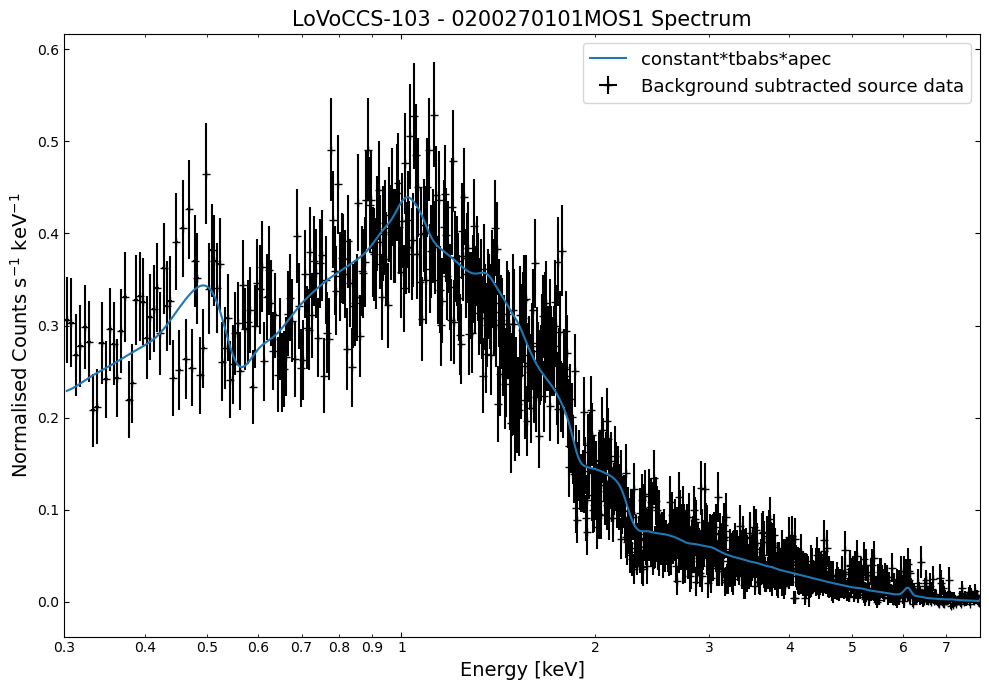

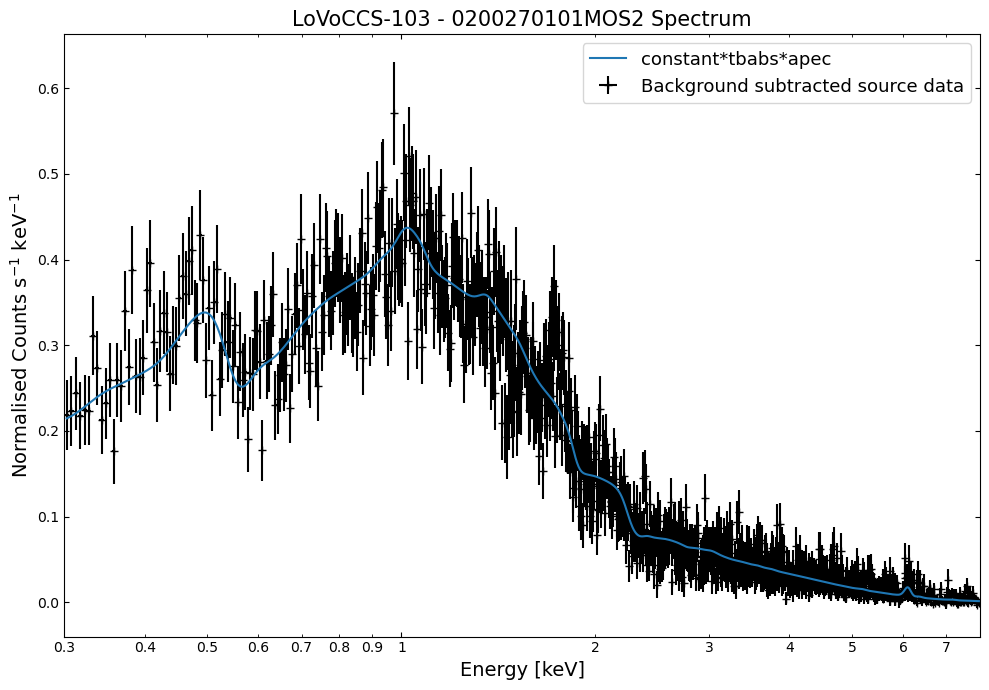

In [103]:
for src in srcs:
    rel_res_ind = np.where(wdem_res['name'].values == src.name)[0][0]
    try:
        mtxs = src.get_results(Quantity(500, 'kpc'), 'constant*tbabs*wdem', par='Tmax')
        wdem_res.loc[rel_res_ind, ['Tmax_500kpc', 'Tmax_500kpc-', 'Tmax_500kpc+']] = mtxs
        
        print(src.name)
        for sp in src.get_spectra(Quantity(500, 'kpc')):
            sp.view()
        
        betas = src.get_results(Quantity(500, 'kpc'), 'constant*tbabs*wdem', par='beta')
        wdem_res.loc[rel_res_ind, ['beta_500kpc', 'beta_500kpc-', 'beta_500kpc+']] = betas
        
        inv_sls = src.get_results(Quantity(500, 'kpc'), 'constant*tbabs*wdem', par='inv_slope')
        wdem_res.loc[rel_res_ind, ['invsl_500kpc', 'invsl_500kpc-', 'invsl_500kpc+']] = inv_sls
        
        mets = src.get_results(Quantity(500, 'kpc'), 'constant*tbabs*wdem', par='abundanc')
        wdem_res.loc[rel_res_ind, ['met_500kpc', 'met_500kpc-', 'met_500kpc+']] = mets
        
        lx52s = src.get_luminosities(Quantity(500, 'kpc'), 'constant*tbabs*wdem', lo_en=Quantity(0.5, 'keV'), 
                                     hi_en=Quantity(2.0, 'keV'))
        wdem_res.loc[rel_res_ind, ['Lx52_500kpc', 'Lx52_500kpc-', 'Lx52_500kpc+']] = lx52s.to('10^44 erg/s').value
        
        lxbols = src.get_luminosities(Quantity(500, 'kpc'), 'constant*tbabs*wdem', lo_en=Quantity(0.01, 'keV'), 
                                      hi_en=Quantity(100.0, 'keV'))
        wdem_res.loc[rel_res_ind, ['Lxbol_500kpc', 'Lxbol_500kpc-', 'Lxbol_500kpc+']] = lxbols.to('10^44 erg/s').value
    except ModelNotAssociatedError:
        pass

### $R_{\rm{out}}=1000\:\rm{kpc}$ & $R^{\rm{back}}_{\rm{inn}}=1050\:\rm{kpc}$ & $R^{\rm{back}}_{\rm{out}}=1500\:\rm{kpc}$

<span style="color:red">This is temporary, XGA will support both setting the background annulus at spectrum generation time, **and** entirely different background methods very soon</span>

In [ ]:
for src in srcs:
    src._back_inn_factor = 1.05
    src._back_out_factor = 1.5

<span style="color:red">Also temporary - need to disassociate observations that cause spectrum generation problems - this will be handled in a more sophisticated way soon</span>

In [ ]:
errors = """SASGenerationError: [[SASGenerationError(' raised by  - - LoVoCCS-1 is the associated source, the specific data used is 0822350101-mos2.'), SASGenerationError("datasetCouldNotBeRead raised by arfgen - The dataset with name '0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.19137752290704207_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0822350101-mos2."), SASGenerationError("datasetCouldNotBeRead raised by specgroup - The dataset with name '0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.19137752290704207_grpTrue_mincnt5.rmf' could not be read; either it does not exist or it is in an unrecognised format- LoVoCCS-1 is the associated source, the specific data used is 0822350101-mos2.")], [SASGenerationError("/bin/sh: line 1: 26241 Segmentation fault      (core dumped) rmfgen rmfset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1."), SASGenerationError('/bin/sh: line 1: 26242 Segmentation fault      (core dumped) arfgen spectrumset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1.'), SASGenerationError('/bin/sh: line 1: 26251 Segmentation fault      (core dumped) backscale spectrumset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1.'), SASGenerationError('/bin/sh: line 1: 28001 Segmentation fault      (core dumped) specgroup spectrumset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1.'), SASGenerationError("/bin/sh: line 1: 26371 Segmentation fault      (core dumped) rmfgen rmfset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0725240101_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1."), SASGenerationError('/bin/sh: line 1: 26373 Segmentation fault      (core dumped) arfgen spectrumset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0725240101_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1.'), SASGenerationError('/bin/sh: line 1: 26378 Segmentation fault      (core dumped) backscale spectrumset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1.'), SASGenerationError('/bin/sh: line 1: 28010 Segmentation fault      (core dumped) specgroup spectrumset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1.'), SASGenerationError("/bin/sh: line 1: 26515 Segmentation fault      (core dumped) rmfgen rmfset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0725240101_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2."), SASGenerationError('/bin/sh: line 1: 26516 Segmentation fault      (core dumped) arfgen spectrumset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0725240101_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2.'), SASGenerationError('/bin/sh: line 1: 26522 Segmentation fault      (core dumped) backscale spectrumset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2.'), SASGenerationError('/bin/sh: line 1: 28129 Segmentation fault      (core dumped) specgroup spectrumset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2.'), SASGenerationError("/bin/sh: line 1: 26486 Segmentation fault      (core dumped) rmfgen rmfset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2."), SASGenerationError('/bin/sh: line 1: 26487 Segmentation fault      (core dumped) arfgen spectrumset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2.'), SASGenerationError('/bin/sh: line 1: 26494 Segmentation fault      (core dumped) backscale spectrumset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2.'), SASGenerationError('/bin/sh: line 1: 28270 Segmentation fault      (core dumped) specgroup spectrumset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2.'), SASGenerationError("/bin/sh: line 1: 26333 Segmentation fault      (core dumped) rmfgen rmfset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn."), SASGenerationError('/bin/sh: line 1: 26336 Segmentation fault      (core dumped) arfgen spectrumset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn.'), SASGenerationError('/bin/sh: line 1: 26345 Segmentation fault      (core dumped) backscale spectrumset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn.'), SASGenerationError('/bin/sh: line 1: 28487 Segmentation fault      (core dumped) specgroup spectrumset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn.'), SASGenerationError("/bin/sh: line 1: 26936 Segmentation fault      (core dumped) rmfgen rmfset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0504260101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1."), SASGenerationError('/bin/sh: line 1: 26937 Segmentation fault      (core dumped) arfgen spectrumset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0504260101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1.'), SASGenerationError('/bin/sh: line 1: 26945 Segmentation fault      (core dumped) backscale spectrumset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1.'), SASGenerationError('/bin/sh: line 1: 28816 Segmentation fault      (core dumped) specgroup spectrumset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1.'), SASGenerationError("/bin/sh: line 1: 26917 Segmentation fault      (core dumped) rmfgen rmfset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0504260101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn."), SASGenerationError('/bin/sh: line 1: 26918 Segmentation fault      (core dumped) arfgen spectrumset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0504260101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn.'), SASGenerationError('/bin/sh: line 1: 26933 Segmentation fault      (core dumped) backscale spectrumset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn.'), SASGenerationError('/bin/sh: line 1: 28937 Segmentation fault      (core dumped) specgroup spectrumset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn.'), SASGenerationError("/bin/sh: line 1: 27378 Segmentation fault      (core dumped) rmfgen rmfset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0504260101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2."), SASGenerationError('/bin/sh: line 1: 27379 Segmentation fault      (core dumped) arfgen spectrumset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0504260101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2.'), SASGenerationError('/bin/sh: line 1: 27386 Segmentation fault      (core dumped) backscale spectrumset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2.'), SASGenerationError('/bin/sh: line 1: 29219 Segmentation fault      (core dumped) specgroup spectrumset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2.'), SASGenerationError("/bin/sh: line 1: 27458 Segmentation fault      (core dumped) rmfgen rmfset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1."), SASGenerationError('/bin/sh: line 1: 27461 Segmentation fault      (core dumped) arfgen spectrumset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1.'), SASGenerationError('/bin/sh: line 1: 27470 Segmentation fault      (core dumped) backscale spectrumset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1.'), SASGenerationError('/bin/sh: line 1: 29257 Segmentation fault      (core dumped) specgroup spectrumset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1.'), SASGenerationError("/bin/sh: line 1: 27465 Segmentation fault      (core dumped) rmfgen rmfset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2."), SASGenerationError('/bin/sh: line 1: 27467 Segmentation fault      (core dumped) arfgen spectrumset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2.'), SASGenerationError('/bin/sh: line 1: 27475 Segmentation fault      (core dumped) backscale spectrumset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2.'), SASGenerationError('/bin/sh: line 1: 29404 Segmentation fault      (core dumped) specgroup spectrumset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2.'), SASGenerationError("/bin/sh: line 1: 27518 Segmentation fault      (core dumped) rmfgen rmfset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440801_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1."), SASGenerationError('/bin/sh: line 1: 27519 Segmentation fault      (core dumped) arfgen spectrumset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440801_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1.'), SASGenerationError('/bin/sh: line 1: 27526 Segmentation fault      (core dumped) backscale spectrumset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1.'), SASGenerationError('/bin/sh: line 1: 29431 Segmentation fault      (core dumped) specgroup spectrumset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1.'), SASGenerationError("/bin/sh: line 1: 27362 Segmentation fault      (core dumped) rmfgen rmfset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn."), SASGenerationError('/bin/sh: line 1: 27363 Segmentation fault      (core dumped) arfgen spectrumset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn.'), SASGenerationError('/bin/sh: line 1: 27375 Segmentation fault      (core dumped) backscale spectrumset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn.'), SASGenerationError('/bin/sh: line 1: 29513 Segmentation fault      (core dumped) specgroup spectrumset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn.'), SASGenerationError("/bin/sh: line 1: 27663 Segmentation fault      (core dumped) rmfgen rmfset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440801_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2."), SASGenerationError('/bin/sh: line 1: 27664 Segmentation fault      (core dumped) arfgen spectrumset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440801_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2.'), SASGenerationError('/bin/sh: line 1: 27710 Segmentation fault      (core dumped) backscale spectrumset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2.'), SASGenerationError('/bin/sh: line 1: 29547 Segmentation fault      (core dumped) specgroup spectrumset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2.'), SASGenerationError("/bin/sh: line 1: 27867 Segmentation fault      (core dumped) rmfgen rmfset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1."), SASGenerationError('/bin/sh: line 1: 27869 Segmentation fault      (core dumped) arfgen spectrumset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1.'), SASGenerationError('/bin/sh: line 1: 27880 Segmentation fault      (core dumped) backscale spectrumset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1.'), SASGenerationError('/bin/sh: line 1: 29733 Segmentation fault      (core dumped) specgroup spectrumset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1.'), SASGenerationError("/bin/sh: line 1: 27930 Segmentation fault      (core dumped) rmfgen rmfset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2."), SASGenerationError('/bin/sh: line 1: 27932 Segmentation fault      (core dumped) arfgen spectrumset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2.'), SASGenerationError('/bin/sh: line 1: 27942 Segmentation fault      (core dumped) backscale spectrumset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2.'), SASGenerationError('/bin/sh: line 1: 29895 Segmentation fault      (core dumped) specgroup spectrumset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2.'), SASGenerationError("/bin/sh: line 1: 28350 Segmentation fault      (core dumped) rmfgen rmfset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1."), SASGenerationError('/bin/sh: line 1: 28352 Segmentation fault      (core dumped) arfgen spectrumset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1.'), SASGenerationError('/bin/sh: line 1: 28421 Segmentation fault      (core dumped) backscale spectrumset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1.'), SASGenerationError('/bin/sh: line 1: 29944 Segmentation fault      (core dumped) specgroup spectrumset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1.'), SASGenerationError("/bin/sh: line 1: 28301 Segmentation fault      (core dumped) rmfgen rmfset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1."), SASGenerationError('/bin/sh: line 1: 28302 Segmentation fault      (core dumped) arfgen spectrumset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1.'), SASGenerationError('/bin/sh: line 1: 28314 Segmentation fault      (core dumped) backscale spectrumset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1.'), SASGenerationError('/bin/sh: line 1: 29965 Segmentation fault      (core dumped) specgroup spectrumset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1.'), SASGenerationError("/bin/sh: line 1: 27857 Segmentation fault      (core dumped) rmfgen rmfset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn."), SASGenerationError('/bin/sh: line 1: 27858 Segmentation fault      (core dumped) arfgen spectrumset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn.'), SASGenerationError('/bin/sh: line 1: 27875 Segmentation fault      (core dumped) backscale spectrumset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn.'), SASGenerationError('/bin/sh: line 1: 29986 Segmentation fault      (core dumped) specgroup spectrumset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn.'), SASGenerationError("/bin/sh: line 1: 28286 Segmentation fault      (core dumped) rmfgen rmfset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440701_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2."), SASGenerationError('/bin/sh: line 1: 28287 Segmentation fault      (core dumped) arfgen spectrumset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440701_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2.'), SASGenerationError('/bin/sh: line 1: 28295 Segmentation fault      (core dumped) backscale spectrumset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2.'), SASGenerationError('/bin/sh: line 1: 30133 Segmentation fault      (core dumped) specgroup spectrumset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2.'), SASGenerationError("/bin/sh: line 1: 28533 Segmentation fault      (core dumped) rmfgen rmfset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1."), SASGenerationError('/bin/sh: line 1: 28534 Segmentation fault      (core dumped) arfgen spectrumset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1.'), SASGenerationError('/bin/sh: line 1: 28548 Segmentation fault      (core dumped) backscale spectrumset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1.'), SASGenerationError('/bin/sh: line 1: 30164 Segmentation fault      (core dumped) specgroup spectrumset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1.'), SASGenerationError("/bin/sh: line 1: 28161 Segmentation fault      (core dumped) rmfgen rmfset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440701_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1."), SASGenerationError('/bin/sh: line 1: 28165 Segmentation fault      (core dumped) arfgen spectrumset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440701_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1.'), SASGenerationError('/bin/sh: line 1: 28261 Segmentation fault      (core dumped) backscale spectrumset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1.'), SASGenerationError('/bin/sh: line 1: 30165 Segmentation fault      (core dumped) specgroup spectrumset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1.'), SASGenerationError("/bin/sh: line 1: 27959 Segmentation fault      (core dumped) rmfgen rmfset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn."), SASGenerationError('/bin/sh: line 1: 27960 Segmentation fault      (core dumped) arfgen spectrumset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn.'), SASGenerationError('/bin/sh: line 1: 27976 Segmentation fault      (core dumped) backscale spectrumset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn.'), SASGenerationError('/bin/sh: line 1: 30210 Segmentation fault      (core dumped) specgroup spectrumset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn.'), SASGenerationError("/bin/sh: line 1: 28308 Segmentation fault      (core dumped) rmfgen rmfset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2."), SASGenerationError('/bin/sh: line 1: 28311 Segmentation fault      (core dumped) arfgen spectrumset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2.'), SASGenerationError('/bin/sh: line 1: 28318 Segmentation fault      (core dumped) backscale spectrumset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2.'), SASGenerationError('/bin/sh: line 1: 30273 Segmentation fault      (core dumped) specgroup spectrumset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2.'), SASGenerationError("/bin/sh: line 1: 28667 Segmentation fault      (core dumped) rmfgen rmfset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1."), SASGenerationError('/bin/sh: line 1: 28668 Segmentation fault      (core dumped) arfgen spectrumset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1.'), SASGenerationError('/bin/sh: line 1: 28677 Segmentation fault      (core dumped) backscale spectrumset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1.'), SASGenerationError('/bin/sh: line 1: 30282 Segmentation fault      (core dumped) specgroup spectrumset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1.'), SASGenerationError("/bin/sh: line 1: 28514 Segmentation fault      (core dumped) rmfgen rmfset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2."), SASGenerationError('/bin/sh: line 1: 28516 Segmentation fault      (core dumped) arfgen spectrumset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2.'), SASGenerationError('/bin/sh: line 1: 28528 Segmentation fault      (core dumped) backscale spectrumset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2.'), SASGenerationError('/bin/sh: line 1: 30306 Segmentation fault      (core dumped) specgroup spectrumset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2.'), SASGenerationError("/bin/sh: line 1: 28576 Segmentation fault      (core dumped) rmfgen rmfset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2."), SASGenerationError('/bin/sh: line 1: 28577 Segmentation fault      (core dumped) arfgen spectrumset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2.'), SASGenerationError('/bin/sh: line 1: 28586 Segmentation fault      (core dumped) backscale spectrumset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2.'), SASGenerationError('/bin/sh: line 1: 30367 Segmentation fault      (core dumped) specgroup spectrumset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2.'), SASGenerationError("/bin/sh: line 1: 28549 Segmentation fault      (core dumped) rmfgen rmfset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1."), SASGenerationError('/bin/sh: line 1: 28553 Segmentation fault      (core dumped) arfgen spectrumset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1.'), SASGenerationError('/bin/sh: line 1: 28561 Segmentation fault      (core dumped) backscale spectrumset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1.'), SASGenerationError('/bin/sh: line 1: 30375 Segmentation fault      (core dumped) specgroup spectrumset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1.'), SASGenerationError("/bin/sh: line 1: 28626 Segmentation fault      (core dumped) rmfgen rmfset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2."), SASGenerationError('/bin/sh: line 1: 28628 Segmentation fault      (core dumped) arfgen spectrumset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2.'), SASGenerationError('/bin/sh: line 1: 28636 Segmentation fault      (core dumped) backscale spectrumset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2.'), SASGenerationError('/bin/sh: line 1: 30425 Segmentation fault      (core dumped) specgroup spectrumset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2.'), SASGenerationError("/bin/sh: line 1: 28839 Segmentation fault      (core dumped) rmfgen rmfset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2."), SASGenerationError('/bin/sh: line 1: 28841 Segmentation fault      (core dumped) arfgen spectrumset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2.'), SASGenerationError('/bin/sh: line 1: 28855 Segmentation fault      (core dumped) backscale spectrumset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2.'), SASGenerationError('/bin/sh: line 1: 30641 Segmentation fault      (core dumped) specgroup spectrumset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2.'), SASGenerationError("/bin/sh: line 1: 28901 Segmentation fault      (core dumped) rmfgen rmfset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn."), SASGenerationError('/bin/sh: line 1: 28902 Segmentation fault      (core dumped) arfgen spectrumset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn.'), SASGenerationError('/bin/sh: line 1: 28918 Segmentation fault      (core dumped) backscale spectrumset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn.'), SASGenerationError('/bin/sh: line 1: 30745 Segmentation fault      (core dumped) specgroup spectrumset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn.'), SASGenerationError("/bin/sh: line 1: 28973 Segmentation fault      (core dumped) rmfgen rmfset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn."), SASGenerationError('/bin/sh: line 1: 28974 Segmentation fault      (core dumped) arfgen spectrumset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn.'), SASGenerationError('/bin/sh: line 1: 29025 Segmentation fault      (core dumped) backscale spectrumset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn.'), SASGenerationError('/bin/sh: line 1: 31006 Segmentation fault      (core dumped) specgroup spectrumset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn.'), SASGenerationError("/bin/sh: line 1: 29115 Segmentation fault      (core dumped) rmfgen rmfset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf spectrumset='0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn."), SASGenerationError('/bin/sh: line 1: 29116 Segmentation fault      (core dumped) arfgen spectrumset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits arfset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn.'), SASGenerationError('/bin/sh: line 1: 29234 Segmentation fault      (core dumped) backscale spectrumset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn.'), SASGenerationError('/bin/sh: line 1: 31123 Segmentation fault      (core dumped) specgroup spectrumset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5_backspec.fits arfset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.arf rmfset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.26483051827855825_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn.')], [SASGenerationError("/bin/sh: line 1: 32848 Segmentation fault      (core dumped) rmfgen rmfset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1."), SASGenerationError('/bin/sh: line 1: 32850 Segmentation fault      (core dumped) arfgen spectrumset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1.'), SASGenerationError('/bin/sh: line 1: 32888 Segmentation fault      (core dumped) backscale spectrumset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1.'), SASGenerationError('/bin/sh: line 1: 33089 Segmentation fault      (core dumped) specgroup spectrumset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1.'), SASGenerationError("/bin/sh: line 1: 32825 Segmentation fault      (core dumped) rmfgen rmfset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1."), SASGenerationError('/bin/sh: line 1: 32826 Segmentation fault      (core dumped) arfgen spectrumset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1.'), SASGenerationError('/bin/sh: line 1: 32830 Segmentation fault      (core dumped) backscale spectrumset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1.'), SASGenerationError('/bin/sh: line 1: 33131 Segmentation fault      (core dumped) specgroup spectrumset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1.'), SASGenerationError("/bin/sh: line 1: 32987 Segmentation fault      (core dumped) rmfgen rmfset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2."), SASGenerationError('/bin/sh: line 1: 32988 Segmentation fault      (core dumped) arfgen spectrumset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2.'), SASGenerationError('/bin/sh: line 1: 32993 Segmentation fault      (core dumped) backscale spectrumset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2.'), SASGenerationError('/bin/sh: line 1: 33211 Segmentation fault      (core dumped) specgroup spectrumset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2.'), SASGenerationError("/bin/sh: line 1: 33014 Segmentation fault      (core dumped) rmfgen rmfset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2."), SASGenerationError('/bin/sh: line 1: 33015 Segmentation fault      (core dumped) arfgen spectrumset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2.'), SASGenerationError('/bin/sh: line 1: 33021 Segmentation fault      (core dumped) backscale spectrumset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2.'), SASGenerationError('/bin/sh: line 1: 33245 Segmentation fault      (core dumped) specgroup spectrumset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2.'), SASGenerationError("/bin/sh: line 1: 32795 Segmentation fault      (core dumped) rmfgen rmfset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030601_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn."), SASGenerationError('/bin/sh: line 1: 32797 Segmentation fault      (core dumped) arfgen spectrumset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030601_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn.'), SASGenerationError('/bin/sh: line 1: 32804 Segmentation fault      (core dumped) backscale spectrumset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn.'), SASGenerationError('/bin/sh: line 1: 33253 Segmentation fault      (core dumped) specgroup spectrumset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn.'), SASGenerationError("/bin/sh: line 1: 33232 Segmentation fault      (core dumped) rmfgen rmfset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1."), SASGenerationError('/bin/sh: line 1: 33233 Segmentation fault      (core dumped) arfgen spectrumset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1.'), SASGenerationError('/bin/sh: line 1: 33238 Segmentation fault      (core dumped) backscale spectrumset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1.'), SASGenerationError('/bin/sh: line 1: 33518 Segmentation fault      (core dumped) specgroup spectrumset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1.'), SASGenerationError("/bin/sh: line 1: 33283 Segmentation fault      (core dumped) rmfgen rmfset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2."), SASGenerationError('/bin/sh: line 1: 33285 Segmentation fault      (core dumped) arfgen spectrumset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2.'), SASGenerationError('/bin/sh: line 1: 33291 Segmentation fault      (core dumped) backscale spectrumset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2.'), SASGenerationError('/bin/sh: line 1: 33562 Segmentation fault      (core dumped) specgroup spectrumset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2.'), SASGenerationError("/bin/sh: line 1: 33149 Segmentation fault      (core dumped) rmfgen rmfset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn."), SASGenerationError('/bin/sh: line 1: 33150 Segmentation fault      (core dumped) arfgen spectrumset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn.'), SASGenerationError('/bin/sh: line 1: 33193 Segmentation fault      (core dumped) backscale spectrumset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn.'), SASGenerationError('/bin/sh: line 1: 33586 Segmentation fault      (core dumped) specgroup spectrumset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn.'), SASGenerationError("/bin/sh: line 1: 33261 Segmentation fault      (core dumped) rmfgen rmfset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn."), SASGenerationError('/bin/sh: line 1: 33262 Segmentation fault      (core dumped) arfgen spectrumset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn.'), SASGenerationError('/bin/sh: line 1: 33269 Segmentation fault      (core dumped) backscale spectrumset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn.'), SASGenerationError('/bin/sh: line 1: 33641 Segmentation fault      (core dumped) specgroup spectrumset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn.'), SASGenerationError("/bin/sh: line 1: 33541 Segmentation fault      (core dumped) rmfgen rmfset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1."), SASGenerationError('/bin/sh: line 1: 33543 Segmentation fault      (core dumped) arfgen spectrumset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1.'), SASGenerationError('/bin/sh: line 1: 33551 Segmentation fault      (core dumped) backscale spectrumset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1.'), SASGenerationError('/bin/sh: line 1: 33752 Segmentation fault      (core dumped) specgroup spectrumset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1.'), SASGenerationError("/bin/sh: line 1: 33573 Segmentation fault      (core dumped) rmfgen rmfset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2."), SASGenerationError('/bin/sh: line 1: 33576 Segmentation fault      (core dumped) arfgen spectrumset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2.'), SASGenerationError('/bin/sh: line 1: 33582 Segmentation fault      (core dumped) backscale spectrumset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2.'), SASGenerationError('/bin/sh: line 1: 33902 Segmentation fault      (core dumped) specgroup spectrumset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2.'), SASGenerationError("/bin/sh: line 1: 33649 Segmentation fault      (core dumped) rmfgen rmfset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1."), SASGenerationError('/bin/sh: line 1: 33651 Segmentation fault      (core dumped) arfgen spectrumset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1.'), SASGenerationError('/bin/sh: line 1: 33657 Segmentation fault      (core dumped) backscale spectrumset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1.'), SASGenerationError('/bin/sh: line 1: 34002 Segmentation fault      (core dumped) specgroup spectrumset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1.'), SASGenerationError("/bin/sh: line 1: 33705 Segmentation fault      (core dumped) rmfgen rmfset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2."), SASGenerationError('/bin/sh: line 1: 33706 Segmentation fault      (core dumped) arfgen spectrumset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2.'), SASGenerationError('/bin/sh: line 1: 33710 Segmentation fault      (core dumped) backscale spectrumset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2.'), SASGenerationError('/bin/sh: line 1: 34021 Segmentation fault      (core dumped) specgroup spectrumset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2.'), SASGenerationError("/bin/sh: line 1: 33662 Segmentation fault      (core dumped) rmfgen rmfset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn."), SASGenerationError('/bin/sh: line 1: 33663 Segmentation fault      (core dumped) arfgen spectrumset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn.'), SASGenerationError('/bin/sh: line 1: 33674 Segmentation fault      (core dumped) backscale spectrumset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn.'), SASGenerationError('/bin/sh: line 1: 34136 Segmentation fault      (core dumped) specgroup spectrumset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn.'), SASGenerationError("/bin/sh: line 1: 33918 Segmentation fault      (core dumped) rmfgen rmfset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn."), SASGenerationError('/bin/sh: line 1: 33919 Segmentation fault      (core dumped) arfgen spectrumset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn.'), SASGenerationError('/bin/sh: line 1: 33938 Segmentation fault      (core dumped) backscale spectrumset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn.'), SASGenerationError('/bin/sh: line 1: 34348 Segmentation fault      (core dumped) specgroup spectrumset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn.'), SASGenerationError("/bin/sh: line 1: 33112 Segmentation fault      (core dumped) rmfgen rmfset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2."), SASGenerationError('/bin/sh: line 1: 33113 Segmentation fault      (core dumped) arfgen spectrumset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2.'), SASGenerationError('/bin/sh: line 1: 33120 Segmentation fault      (core dumped) backscale spectrumset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2.'), SASGenerationError('/bin/sh: line 1: 35146 Segmentation fault      (core dumped) specgroup spectrumset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2.'), SASGenerationError("/bin/sh: line 1: 33685 Segmentation fault      (core dumped) rmfgen rmfset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521201_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1."), SASGenerationError('/bin/sh: line 1: 33686 Segmentation fault      (core dumped) arfgen spectrumset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521201_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1.'), SASGenerationError('/bin/sh: line 1: 33693 Segmentation fault      (core dumped) backscale spectrumset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1.'), SASGenerationError('/bin/sh: line 1: 35816 Segmentation fault      (core dumped) specgroup spectrumset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1.'), SASGenerationError("/bin/sh: line 1: 33850 Segmentation fault      (core dumped) rmfgen rmfset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf spectrumset='0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521201_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2."), SASGenerationError('/bin/sh: line 1: 33851 Segmentation fault      (core dumped) arfgen spectrumset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits arfset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521201_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2.'), SASGenerationError('/bin/sh: line 1: 33857 Segmentation fault      (core dumped) backscale spectrumset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2.'), SASGenerationError('/bin/sh: line 1: 35823 Segmentation fault      (core dumped) specgroup spectrumset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5_backspec.fits arfset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.arf rmfset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.4639528138680823_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2.')], [SASGenerationError("/bin/sh: line 1: 36063 Segmentation fault      (core dumped) rmfgen rmfset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0135120201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1."), SASGenerationError('/bin/sh: line 1: 36064 Segmentation fault      (core dumped) arfgen spectrumset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0135120201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1.'), SASGenerationError('/bin/sh: line 1: 36068 Segmentation fault      (core dumped) backscale spectrumset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1.'), SASGenerationError('/bin/sh: line 1: 36172 Segmentation fault      (core dumped) specgroup spectrumset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1.'), SASGenerationError("/bin/sh: line 1: 35752 Segmentation fault      (core dumped) rmfgen rmfset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn."), SASGenerationError('/bin/sh: line 1: 35755 Segmentation fault      (core dumped) arfgen spectrumset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn.'), SASGenerationError('/bin/sh: line 1: 35765 Segmentation fault      (core dumped) backscale spectrumset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn.'), SASGenerationError('/bin/sh: line 1: 36180 Segmentation fault      (core dumped) specgroup spectrumset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn.'), SASGenerationError("/bin/sh: line 1: 36085 Segmentation fault      (core dumped) rmfgen rmfset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0135120201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2."), SASGenerationError('/bin/sh: line 1: 36086 Segmentation fault      (core dumped) arfgen spectrumset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0135120201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2.'), SASGenerationError('/bin/sh: line 1: 36091 Segmentation fault      (core dumped) backscale spectrumset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2.'), SASGenerationError('/bin/sh: line 1: 36216 Segmentation fault      (core dumped) specgroup spectrumset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2.'), SASGenerationError("/bin/sh: line 1: 35801 Segmentation fault      (core dumped) rmfgen rmfset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1."), SASGenerationError('/bin/sh: line 1: 35802 Segmentation fault      (core dumped) arfgen spectrumset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1.'), SASGenerationError('/bin/sh: line 1: 35806 Segmentation fault      (core dumped) backscale spectrumset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1.'), SASGenerationError('/bin/sh: line 1: 36417 Segmentation fault      (core dumped) specgroup spectrumset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1.'), SASGenerationError("/bin/sh: line 1: 36133 Segmentation fault      (core dumped) rmfgen rmfset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0135120201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn."), SASGenerationError('/bin/sh: line 1: 36135 Segmentation fault      (core dumped) arfgen spectrumset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0135120201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn.'), SASGenerationError('/bin/sh: line 1: 36144 Segmentation fault      (core dumped) backscale spectrumset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn.'), SASGenerationError('/bin/sh: line 1: 36427 Segmentation fault      (core dumped) specgroup spectrumset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn.'), SASGenerationError("/bin/sh: line 1: 36041 Segmentation fault      (core dumped) rmfgen rmfset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2."), SASGenerationError('/bin/sh: line 1: 36043 Segmentation fault      (core dumped) arfgen spectrumset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2.'), SASGenerationError('/bin/sh: line 1: 36047 Segmentation fault      (core dumped) backscale spectrumset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2.'), SASGenerationError('/bin/sh: line 1: 36485 Segmentation fault      (core dumped) specgroup spectrumset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2.'), SASGenerationError("/bin/sh: line 1: 36119 Segmentation fault      (core dumped) rmfgen rmfset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn."), SASGenerationError('/bin/sh: line 1: 36120 Segmentation fault      (core dumped) arfgen spectrumset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn.'), SASGenerationError('/bin/sh: line 1: 36132 Segmentation fault      (core dumped) backscale spectrumset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn.'), SASGenerationError('/bin/sh: line 1: 36690 Segmentation fault      (core dumped) specgroup spectrumset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn.'), SASGenerationError("/bin/sh: line 1: 36524 Segmentation fault      (core dumped) rmfgen rmfset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1."), SASGenerationError('/bin/sh: line 1: 36525 Segmentation fault      (core dumped) arfgen spectrumset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1.'), SASGenerationError('/bin/sh: line 1: 36536 Segmentation fault      (core dumped) backscale spectrumset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1.'), SASGenerationError('/bin/sh: line 1: 36706 Segmentation fault      (core dumped) specgroup spectrumset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1.'), SASGenerationError("/bin/sh: line 1: 36195 Segmentation fault      (core dumped) rmfgen rmfset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1."), SASGenerationError('/bin/sh: line 1: 36196 Segmentation fault      (core dumped) arfgen spectrumset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1.'), SASGenerationError('/bin/sh: line 1: 36204 Segmentation fault      (core dumped) backscale spectrumset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1.'), SASGenerationError('/bin/sh: line 1: 36719 Segmentation fault      (core dumped) specgroup spectrumset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1.'), SASGenerationError("/bin/sh: line 1: 36554 Segmentation fault      (core dumped) rmfgen rmfset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095010901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2."), SASGenerationError('/bin/sh: line 1: 36555 Segmentation fault      (core dumped) arfgen spectrumset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095010901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095010901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2.'), SASGenerationError('/bin/sh: line 1: 36558 Segmentation fault      (core dumped) backscale spectrumset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095010901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2.'), SASGenerationError('/bin/sh: line 1: 36729 Segmentation fault      (core dumped) specgroup spectrumset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2.'), SASGenerationError("/bin/sh: line 1: 36572 Segmentation fault      (core dumped) rmfgen rmfset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2."), SASGenerationError('/bin/sh: line 1: 36573 Segmentation fault      (core dumped) arfgen spectrumset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2.'), SASGenerationError('/bin/sh: line 1: 36578 Segmentation fault      (core dumped) backscale spectrumset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2.'), SASGenerationError('/bin/sh: line 1: 36749 Segmentation fault      (core dumped) specgroup spectrumset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2.'), SASGenerationError("/bin/sh: line 1: 36403 Segmentation fault      (core dumped) rmfgen rmfset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2."), SASGenerationError('/bin/sh: line 1: 36404 Segmentation fault      (core dumped) arfgen spectrumset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2.'), SASGenerationError('/bin/sh: line 1: 36408 Segmentation fault      (core dumped) backscale spectrumset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2.'), SASGenerationError('/bin/sh: line 1: 37017 Segmentation fault      (core dumped) specgroup spectrumset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2.'), SASGenerationError("/bin/sh: line 1: 36904 Segmentation fault      (core dumped) rmfgen rmfset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1."), SASGenerationError('/bin/sh: line 1: 36905 Segmentation fault      (core dumped) arfgen spectrumset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1.'), SASGenerationError('/bin/sh: line 1: 36913 Segmentation fault      (core dumped) backscale spectrumset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1.'), SASGenerationError('/bin/sh: line 1: 37072 Segmentation fault      (core dumped) specgroup spectrumset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1.'), SASGenerationError("/bin/sh: line 1: 36916 Segmentation fault      (core dumped) rmfgen rmfset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2."), SASGenerationError('/bin/sh: line 1: 36918 Segmentation fault      (core dumped) arfgen spectrumset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2.'), SASGenerationError('/bin/sh: line 1: 36930 Segmentation fault      (core dumped) backscale spectrumset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2.'), SASGenerationError('/bin/sh: line 1: 37095 Segmentation fault      (core dumped) specgroup spectrumset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2.'), SASGenerationError("/bin/sh: line 1: 36873 Segmentation fault      (core dumped) rmfgen rmfset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn."), SASGenerationError('/bin/sh: line 1: 36874 Segmentation fault      (core dumped) arfgen spectrumset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn.'), SASGenerationError('/bin/sh: line 1: 36888 Segmentation fault      (core dumped) backscale spectrumset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn.'), SASGenerationError('/bin/sh: line 1: 37125 Segmentation fault      (core dumped) specgroup spectrumset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn.'), SASGenerationError("/bin/sh: line 1: 37167 Segmentation fault      (core dumped) rmfgen rmfset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn."), SASGenerationError('/bin/sh: line 1: 37168 Segmentation fault      (core dumped) arfgen spectrumset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn.'), SASGenerationError('/bin/sh: line 1: 37177 Segmentation fault      (core dumped) backscale spectrumset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn.'), SASGenerationError('/bin/sh: line 1: 37447 Segmentation fault      (core dumped) specgroup spectrumset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn.'), SASGenerationError("/bin/sh: line 1: 36531 Segmentation fault      (core dumped) rmfgen rmfset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1."), SASGenerationError('/bin/sh: line 1: 36532 Segmentation fault      (core dumped) arfgen spectrumset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1.'), SASGenerationError('/bin/sh: line 1: 36542 Segmentation fault      (core dumped) backscale spectrumset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1.'), SASGenerationError('/bin/sh: line 1: 37489 Segmentation fault      (core dumped) specgroup spectrumset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1.'), SASGenerationError("/bin/sh: line 1: 36533 Segmentation fault      (core dumped) rmfgen rmfset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn."), SASGenerationError('/bin/sh: line 1: 36538 Segmentation fault      (core dumped) arfgen spectrumset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn.'), SASGenerationError('/bin/sh: line 1: 36547 Segmentation fault      (core dumped) backscale spectrumset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn.'), SASGenerationError('/bin/sh: line 1: 37506 Segmentation fault      (core dumped) specgroup spectrumset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn.'), SASGenerationError("/bin/sh: line 1: 36589 Segmentation fault      (core dumped) rmfgen rmfset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf spectrumset='0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2."), SASGenerationError('/bin/sh: line 1: 36591 Segmentation fault      (core dumped) arfgen spectrumset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits arfset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2.'), SASGenerationError('/bin/sh: line 1: 36594 Segmentation fault      (core dumped) backscale spectrumset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2.'), SASGenerationError('/bin/sh: line 1: 37551 Segmentation fault      (core dumped) specgroup spectrumset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5_backspec.fits arfset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.arf rmfset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42690729665320243_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2.')], [SASGenerationError("/bin/sh: line 1: 41292 Segmentation fault      (core dumped) rmfgen rmfset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1."), SASGenerationError('/bin/sh: line 1: 41293 Segmentation fault      (core dumped) arfgen spectrumset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1.'), SASGenerationError('/bin/sh: line 1: 41297 Segmentation fault      (core dumped) backscale spectrumset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1.'), SASGenerationError('/bin/sh: line 1: 41859 Segmentation fault      (core dumped) specgroup spectrumset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1.'), SASGenerationError("/bin/sh: line 1: 41228 Segmentation fault      (core dumped) rmfgen rmfset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn."), SASGenerationError('/bin/sh: line 1: 41229 Segmentation fault      (core dumped) arfgen spectrumset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn.'), SASGenerationError('/bin/sh: line 1: 41236 Segmentation fault      (core dumped) backscale spectrumset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn.'), SASGenerationError('/bin/sh: line 1: 41867 Segmentation fault      (core dumped) specgroup spectrumset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn.'), SASGenerationError("/bin/sh: line 1: 41390 Segmentation fault      (core dumped) rmfgen rmfset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2."), SASGenerationError('/bin/sh: line 1: 41392 Segmentation fault      (core dumped) arfgen spectrumset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2.'), SASGenerationError('/bin/sh: line 1: 41395 Segmentation fault      (core dumped) backscale spectrumset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2.'), SASGenerationError('/bin/sh: line 1: 42006 Segmentation fault      (core dumped) specgroup spectrumset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2.'), SASGenerationError("/bin/sh: line 1: 41536 Segmentation fault      (core dumped) rmfgen rmfset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801001_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1."), SASGenerationError('/bin/sh: line 1: 41560 Segmentation fault      (core dumped) arfgen spectrumset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801001_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1.'), SASGenerationError('/bin/sh: line 1: 41565 Segmentation fault      (core dumped) backscale spectrumset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1.'), SASGenerationError('/bin/sh: line 1: 42182 Segmentation fault      (core dumped) specgroup spectrumset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1.'), SASGenerationError("/bin/sh: line 1: 41694 Segmentation fault      (core dumped) rmfgen rmfset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801001_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn."), SASGenerationError('/bin/sh: line 1: 41696 Segmentation fault      (core dumped) arfgen spectrumset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801001_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn.'), SASGenerationError('/bin/sh: line 1: 41703 Segmentation fault      (core dumped) backscale spectrumset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn.'), SASGenerationError('/bin/sh: line 1: 42453 Segmentation fault      (core dumped) specgroup spectrumset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn.'), SASGenerationError("/bin/sh: line 1: 42057 Segmentation fault      (core dumped) rmfgen rmfset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801001_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2."), SASGenerationError('/bin/sh: line 1: 42058 Segmentation fault      (core dumped) arfgen spectrumset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801001_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2.'), SASGenerationError('/bin/sh: line 1: 42062 Segmentation fault      (core dumped) backscale spectrumset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2.'), SASGenerationError('/bin/sh: line 1: 42811 Segmentation fault      (core dumped) specgroup spectrumset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2.'), SASGenerationError("/bin/sh: line 1: 42167 Segmentation fault      (core dumped) rmfgen rmfset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723800901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1."), SASGenerationError('/bin/sh: line 1: 42168 Segmentation fault      (core dumped) arfgen spectrumset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723800901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1.'), SASGenerationError('/bin/sh: line 1: 42173 Segmentation fault      (core dumped) backscale spectrumset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1.'), SASGenerationError('/bin/sh: line 1: 42847 Segmentation fault      (core dumped) specgroup spectrumset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1.'), SASGenerationError("/bin/sh: line 1: 42120 Segmentation fault      (core dumped) rmfgen rmfset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723800901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn."), SASGenerationError('/bin/sh: line 1: 42121 Segmentation fault      (core dumped) arfgen spectrumset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723800901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn.'), SASGenerationError('/bin/sh: line 1: 42163 Segmentation fault      (core dumped) backscale spectrumset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn.'), SASGenerationError('/bin/sh: line 1: 42869 Segmentation fault      (core dumped) specgroup spectrumset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn.'), SASGenerationError("/bin/sh: line 1: 42227 Segmentation fault      (core dumped) rmfgen rmfset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723800901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2."), SASGenerationError('/bin/sh: line 1: 42229 Segmentation fault      (core dumped) arfgen spectrumset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723800901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2.'), SASGenerationError('/bin/sh: line 1: 42233 Segmentation fault      (core dumped) backscale spectrumset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2.'), SASGenerationError('/bin/sh: line 1: 42887 Segmentation fault      (core dumped) specgroup spectrumset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2.'), SASGenerationError("/bin/sh: line 1: 42207 Segmentation fault      (core dumped) rmfgen rmfset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn."), SASGenerationError('/bin/sh: line 1: 42208 Segmentation fault      (core dumped) arfgen spectrumset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn.'), SASGenerationError('/bin/sh: line 1: 42213 Segmentation fault      (core dumped) backscale spectrumset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn.'), SASGenerationError('/bin/sh: line 1: 42928 Segmentation fault      (core dumped) specgroup spectrumset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn.'), SASGenerationError("/bin/sh: line 1: 42256 Segmentation fault      (core dumped) rmfgen rmfset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1."), SASGenerationError('/bin/sh: line 1: 42257 Segmentation fault      (core dumped) arfgen spectrumset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1.'), SASGenerationError('/bin/sh: line 1: 42262 Segmentation fault      (core dumped) backscale spectrumset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1.'), SASGenerationError('/bin/sh: line 1: 42958 Segmentation fault      (core dumped) specgroup spectrumset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1.'), SASGenerationError("/bin/sh: line 1: 42527 Segmentation fault      (core dumped) rmfgen rmfset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf spectrumset='0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2."), SASGenerationError('/bin/sh: line 1: 42529 Segmentation fault      (core dumped) arfgen spectrumset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits arfset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2.'), SASGenerationError('/bin/sh: line 1: 42532 Segmentation fault      (core dumped) backscale spectrumset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2.'), SASGenerationError('/bin/sh: line 1: 43226 Segmentation fault      (core dumped) specgroup spectrumset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5_backspec.fits arfset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.arf rmfset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.2982445266993849_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2.')], [SASGenerationError("/bin/sh: line 1: 46583 Segmentation fault      (core dumped) rmfgen rmfset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1."), SASGenerationError('/bin/sh: line 1: 46584 Segmentation fault      (core dumped) arfgen spectrumset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1.'), SASGenerationError('/bin/sh: line 1: 46589 Segmentation fault      (core dumped) backscale spectrumset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1.'), SASGenerationError('/bin/sh: line 1: 46687 Segmentation fault      (core dumped) specgroup spectrumset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1.'), SASGenerationError("/bin/sh: line 1: 46627 Segmentation fault      (core dumped) rmfgen rmfset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn."), SASGenerationError('/bin/sh: line 1: 46628 Segmentation fault      (core dumped) arfgen spectrumset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn.'), SASGenerationError('/bin/sh: line 1: 46635 Segmentation fault      (core dumped) backscale spectrumset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn.'), SASGenerationError('/bin/sh: line 1: 46912 Segmentation fault      (core dumped) specgroup spectrumset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn.'), SASGenerationError("/bin/sh: line 1: 46903 Segmentation fault      (core dumped) rmfgen rmfset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2."), SASGenerationError('/bin/sh: line 1: 46905 Segmentation fault      (core dumped) arfgen spectrumset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2.'), SASGenerationError('/bin/sh: line 1: 46908 Segmentation fault      (core dumped) backscale spectrumset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2.'), SASGenerationError('/bin/sh: line 1: 47076 Segmentation fault      (core dumped) specgroup spectrumset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2.'), SASGenerationError("/bin/sh: line 1: 47032 Segmentation fault      (core dumped) rmfgen rmfset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1."), SASGenerationError('/bin/sh: line 1: 47035 Segmentation fault      (core dumped) arfgen spectrumset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1.'), SASGenerationError('/bin/sh: line 1: 47039 Segmentation fault      (core dumped) backscale spectrumset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1.'), SASGenerationError('/bin/sh: line 1: 47247 Segmentation fault      (core dumped) specgroup spectrumset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1.'), SASGenerationError("/bin/sh: line 1: 46952 Segmentation fault      (core dumped) rmfgen rmfset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn."), SASGenerationError('/bin/sh: line 1: 46955 Segmentation fault      (core dumped) arfgen spectrumset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn.'), SASGenerationError('/bin/sh: line 1: 46961 Segmentation fault      (core dumped) backscale spectrumset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn.'), SASGenerationError('/bin/sh: line 1: 47265 Segmentation fault      (core dumped) specgroup spectrumset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn.'), SASGenerationError("/bin/sh: line 1: 47047 Segmentation fault      (core dumped) rmfgen rmfset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2."), SASGenerationError('/bin/sh: line 1: 47048 Segmentation fault      (core dumped) arfgen spectrumset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2.'), SASGenerationError('/bin/sh: line 1: 47052 Segmentation fault      (core dumped) backscale spectrumset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2.'), SASGenerationError('/bin/sh: line 1: 47288 Segmentation fault      (core dumped) specgroup spectrumset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2.'), SASGenerationError("/bin/sh: line 1: 47273 Segmentation fault      (core dumped) rmfgen rmfset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1."), SASGenerationError('/bin/sh: line 1: 47274 Segmentation fault      (core dumped) arfgen spectrumset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1.'), SASGenerationError('/bin/sh: line 1: 47278 Segmentation fault      (core dumped) backscale spectrumset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1.'), SASGenerationError('/bin/sh: line 1: 47454 Segmentation fault      (core dumped) specgroup spectrumset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1.'), SASGenerationError("/bin/sh: line 1: 47242 Segmentation fault      (core dumped) rmfgen rmfset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn."), SASGenerationError('/bin/sh: line 1: 47243 Segmentation fault      (core dumped) arfgen spectrumset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn.'), SASGenerationError('/bin/sh: line 1: 47256 Segmentation fault      (core dumped) backscale spectrumset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn.'), SASGenerationError('/bin/sh: line 1: 47545 Segmentation fault      (core dumped) specgroup spectrumset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn.'), SASGenerationError("/bin/sh: line 1: 47422 Segmentation fault      (core dumped) rmfgen rmfset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1."), SASGenerationError('/bin/sh: line 1: 47423 Segmentation fault      (core dumped) arfgen spectrumset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1.'), SASGenerationError('/bin/sh: line 1: 47427 Segmentation fault      (core dumped) backscale spectrumset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1.'), SASGenerationError('/bin/sh: line 1: 47574 Segmentation fault      (core dumped) specgroup spectrumset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1.'), SASGenerationError("/bin/sh: line 1: 47399 Segmentation fault      (core dumped) rmfgen rmfset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2."), SASGenerationError('/bin/sh: line 1: 47400 Segmentation fault      (core dumped) arfgen spectrumset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2.'), SASGenerationError('/bin/sh: line 1: 47405 Segmentation fault      (core dumped) backscale spectrumset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2.'), SASGenerationError('/bin/sh: line 1: 47616 Segmentation fault      (core dumped) specgroup spectrumset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2.'), SASGenerationError("/bin/sh: line 1: 47467 Segmentation fault      (core dumped) rmfgen rmfset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2."), SASGenerationError('/bin/sh: line 1: 47469 Segmentation fault      (core dumped) arfgen spectrumset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2.'), SASGenerationError('/bin/sh: line 1: 47473 Segmentation fault      (core dumped) backscale spectrumset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2.'), SASGenerationError('/bin/sh: line 1: 47727 Segmentation fault      (core dumped) specgroup spectrumset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2.'), SASGenerationError("/bin/sh: line 1: 47487 Segmentation fault      (core dumped) rmfgen rmfset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1."), SASGenerationError('/bin/sh: line 1: 47489 Segmentation fault      (core dumped) arfgen spectrumset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1.'), SASGenerationError('/bin/sh: line 1: 47493 Segmentation fault      (core dumped) backscale spectrumset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1.'), SASGenerationError('/bin/sh: line 1: 47774 Segmentation fault      (core dumped) specgroup spectrumset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1.'), SASGenerationError("/bin/sh: line 1: 47418 Segmentation fault      (core dumped) rmfgen rmfset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn."), SASGenerationError('/bin/sh: line 1: 47419 Segmentation fault      (core dumped) arfgen spectrumset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn.'), SASGenerationError('/bin/sh: line 1: 47430 Segmentation fault      (core dumped) backscale spectrumset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn.'), SASGenerationError('/bin/sh: line 1: 47789 Segmentation fault      (core dumped) specgroup spectrumset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn.'), SASGenerationError("/bin/sh: line 1: 47536 Segmentation fault      (core dumped) rmfgen rmfset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2."), SASGenerationError('/bin/sh: line 1: 47538 Segmentation fault      (core dumped) arfgen spectrumset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2.'), SASGenerationError('/bin/sh: line 1: 47543 Segmentation fault      (core dumped) backscale spectrumset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2.'), SASGenerationError('/bin/sh: line 1: 47827 Segmentation fault      (core dumped) specgroup spectrumset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2.'), SASGenerationError("/bin/sh: line 1: 47859 Segmentation fault      (core dumped) rmfgen rmfset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1."), SASGenerationError('/bin/sh: line 1: 47861 Segmentation fault      (core dumped) arfgen spectrumset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1.'), SASGenerationError('/bin/sh: line 1: 47864 Segmentation fault      (core dumped) backscale spectrumset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1.'), SASGenerationError('/bin/sh: line 1: 48104 Segmentation fault      (core dumped) specgroup spectrumset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1.'), SASGenerationError("/bin/sh: line 1: 47913 Segmentation fault      (core dumped) rmfgen rmfset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2."), SASGenerationError('/bin/sh: line 1: 47916 Segmentation fault      (core dumped) arfgen spectrumset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2.'), SASGenerationError('/bin/sh: line 1: 47919 Segmentation fault      (core dumped) backscale spectrumset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2.'), SASGenerationError('/bin/sh: line 1: 48141 Segmentation fault      (core dumped) specgroup spectrumset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2.'), SASGenerationError("/bin/sh: line 1: 47836 Segmentation fault      (core dumped) rmfgen rmfset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521601_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn."), SASGenerationError('/bin/sh: line 1: 47837 Segmentation fault      (core dumped) arfgen spectrumset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521601_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn.'), SASGenerationError('/bin/sh: line 1: 47842 Segmentation fault      (core dumped) backscale spectrumset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn.'), SASGenerationError('/bin/sh: line 1: 48257 Segmentation fault      (core dumped) specgroup spectrumset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn.'), SASGenerationError("/bin/sh: line 1: 47964 Segmentation fault      (core dumped) rmfgen rmfset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1."), SASGenerationError('/bin/sh: line 1: 47966 Segmentation fault      (core dumped) arfgen spectrumset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1.'), SASGenerationError('/bin/sh: line 1: 47969 Segmentation fault      (core dumped) backscale spectrumset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1.'), SASGenerationError('/bin/sh: line 1: 48265 Segmentation fault      (core dumped) specgroup spectrumset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1.'), SASGenerationError("/bin/sh: line 1: 48031 Segmentation fault      (core dumped) rmfgen rmfset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1."), SASGenerationError('/bin/sh: line 1: 48032 Segmentation fault      (core dumped) arfgen spectrumset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1.'), SASGenerationError('/bin/sh: line 1: 48038 Segmentation fault      (core dumped) backscale spectrumset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1.'), SASGenerationError('/bin/sh: line 1: 48310 Segmentation fault      (core dumped) specgroup spectrumset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1.'), SASGenerationError("/bin/sh: line 1: 48026 Segmentation fault      (core dumped) rmfgen rmfset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2."), SASGenerationError('/bin/sh: line 1: 48027 Segmentation fault      (core dumped) arfgen spectrumset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2.'), SASGenerationError('/bin/sh: line 1: 48035 Segmentation fault      (core dumped) backscale spectrumset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2.'), SASGenerationError('/bin/sh: line 1: 48339 Segmentation fault      (core dumped) specgroup spectrumset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2.'), SASGenerationError("/bin/sh: line 1: 47929 Segmentation fault      (core dumped) rmfgen rmfset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn."), SASGenerationError('/bin/sh: line 1: 47931 Segmentation fault      (core dumped) arfgen spectrumset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn.'), SASGenerationError('/bin/sh: line 1: 47936 Segmentation fault      (core dumped) backscale spectrumset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn.'), SASGenerationError('/bin/sh: line 1: 48356 Segmentation fault      (core dumped) specgroup spectrumset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn.'), SASGenerationError("/bin/sh: line 1: 48097 Segmentation fault      (core dumped) rmfgen rmfset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1."), SASGenerationError('/bin/sh: line 1: 48098 Segmentation fault      (core dumped) arfgen spectrumset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1.'), SASGenerationError('/bin/sh: line 1: 48103 Segmentation fault      (core dumped) backscale spectrumset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1.'), SASGenerationError('/bin/sh: line 1: 48388 Segmentation fault      (core dumped) specgroup spectrumset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1.'), SASGenerationError("/bin/sh: line 1: 48040 Segmentation fault      (core dumped) rmfgen rmfset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn."), SASGenerationError('/bin/sh: line 1: 48041 Segmentation fault      (core dumped) arfgen spectrumset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn.'), SASGenerationError('/bin/sh: line 1: 48047 Segmentation fault      (core dumped) backscale spectrumset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn.'), SASGenerationError('/bin/sh: line 1: 48491 Segmentation fault      (core dumped) specgroup spectrumset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn.'), SASGenerationError("/bin/sh: line 1: 48056 Segmentation fault      (core dumped) rmfgen rmfset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520801_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn."), SASGenerationError('/bin/sh: line 1: 48058 Segmentation fault      (core dumped) arfgen spectrumset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520801_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn.'), SASGenerationError('/bin/sh: line 1: 48063 Segmentation fault      (core dumped) backscale spectrumset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn.'), SASGenerationError('/bin/sh: line 1: 48505 Segmentation fault      (core dumped) specgroup spectrumset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn.'), SASGenerationError("/bin/sh: line 1: 48284 Segmentation fault      (core dumped) rmfgen rmfset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2."), SASGenerationError('/bin/sh: line 1: 48285 Segmentation fault      (core dumped) arfgen spectrumset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2.'), SASGenerationError('/bin/sh: line 1: 48290 Segmentation fault      (core dumped) backscale spectrumset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2.'), SASGenerationError('/bin/sh: line 1: 48582 Segmentation fault      (core dumped) specgroup spectrumset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2.'), SASGenerationError("/bin/sh: line 1: 48334 Segmentation fault      (core dumped) rmfgen rmfset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2."), SASGenerationError('/bin/sh: line 1: 48335 Segmentation fault      (core dumped) arfgen spectrumset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2.'), SASGenerationError('/bin/sh: line 1: 48342 Segmentation fault      (core dumped) backscale spectrumset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2.'), SASGenerationError('/bin/sh: line 1: 48697 Segmentation fault      (core dumped) specgroup spectrumset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2.'), SASGenerationError("/bin/sh: line 1: 48391 Segmentation fault      (core dumped) rmfgen rmfset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1."), SASGenerationError('/bin/sh: line 1: 48397 Segmentation fault      (core dumped) arfgen spectrumset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1.'), SASGenerationError('/bin/sh: line 1: 48403 Segmentation fault      (core dumped) backscale spectrumset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1.'), SASGenerationError('/bin/sh: line 1: 48719 Segmentation fault      (core dumped) specgroup spectrumset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1.'), SASGenerationError("/bin/sh: line 1: 48452 Segmentation fault      (core dumped) rmfgen rmfset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1."), SASGenerationError('/bin/sh: line 1: 48454 Segmentation fault      (core dumped) arfgen spectrumset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1.'), SASGenerationError('/bin/sh: line 1: 48459 Segmentation fault      (core dumped) backscale spectrumset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1.'), SASGenerationError('/bin/sh: line 1: 48738 Segmentation fault      (core dumped) specgroup spectrumset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1.'), SASGenerationError("/bin/sh: line 1: 48383 Segmentation fault      (core dumped) rmfgen rmfset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn."), SASGenerationError('/bin/sh: line 1: 48385 Segmentation fault      (core dumped) arfgen spectrumset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn.'), SASGenerationError('/bin/sh: line 1: 48401 Segmentation fault      (core dumped) backscale spectrumset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn.'), SASGenerationError('/bin/sh: line 1: 48931 Segmentation fault      (core dumped) specgroup spectrumset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn.'), SASGenerationError("/bin/sh: line 1: 48574 Segmentation fault      (core dumped) rmfgen rmfset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1."), SASGenerationError('/bin/sh: line 1: 48578 Segmentation fault      (core dumped) arfgen spectrumset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1.'), SASGenerationError('/bin/sh: line 1: 48617 Segmentation fault      (core dumped) backscale spectrumset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1.'), SASGenerationError('/bin/sh: line 1: 48944 Segmentation fault      (core dumped) specgroup spectrumset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1.'), SASGenerationError("/bin/sh: line 1: 48481 Segmentation fault      (core dumped) rmfgen rmfset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520601_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn."), SASGenerationError('/bin/sh: line 1: 48482 Segmentation fault      (core dumped) arfgen spectrumset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520601_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn.'), SASGenerationError('/bin/sh: line 1: 48489 Segmentation fault      (core dumped) backscale spectrumset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn.'), SASGenerationError('/bin/sh: line 1: 48958 Segmentation fault      (core dumped) specgroup spectrumset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn.'), SASGenerationError("/bin/sh: line 1: 48632 Segmentation fault      (core dumped) rmfgen rmfset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2."), SASGenerationError('/bin/sh: line 1: 48633 Segmentation fault      (core dumped) arfgen spectrumset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2.'), SASGenerationError('/bin/sh: line 1: 48663 Segmentation fault      (core dumped) backscale spectrumset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2.'), SASGenerationError('/bin/sh: line 1: 48982 Segmentation fault      (core dumped) specgroup spectrumset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2.'), SASGenerationError("/bin/sh: line 1: 48577 Segmentation fault      (core dumped) rmfgen rmfset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2."), SASGenerationError('/bin/sh: line 1: 48579 Segmentation fault      (core dumped) arfgen spectrumset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2.'), SASGenerationError('/bin/sh: line 1: 48618 Segmentation fault      (core dumped) backscale spectrumset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2.'), SASGenerationError('/bin/sh: line 1: 48991 Segmentation fault      (core dumped) specgroup spectrumset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2.'), SASGenerationError("/bin/sh: line 1: 48687 Segmentation fault      (core dumped) rmfgen rmfset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520501_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn."), SASGenerationError('/bin/sh: line 1: 48690 Segmentation fault      (core dumped) arfgen spectrumset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520501_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn.'), SASGenerationError('/bin/sh: line 1: 48715 Segmentation fault      (core dumped) backscale spectrumset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn.'), SASGenerationError('/bin/sh: line 1: 49077 Segmentation fault      (core dumped) specgroup spectrumset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn.'), SASGenerationError("/bin/sh: line 1: 47766 Segmentation fault      (core dumped) rmfgen rmfset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1."), SASGenerationError('/bin/sh: line 1: 47767 Segmentation fault      (core dumped) arfgen spectrumset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1.'), SASGenerationError('/bin/sh: line 1: 47773 Segmentation fault      (core dumped) backscale spectrumset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1.'), SASGenerationError('/bin/sh: line 1: 49426 Segmentation fault      (core dumped) specgroup spectrumset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1.'), SASGenerationError("/bin/sh: line 1: 47744 Segmentation fault      (core dumped) rmfgen rmfset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn."), SASGenerationError('/bin/sh: line 1: 47745 Segmentation fault      (core dumped) arfgen spectrumset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn.'), SASGenerationError('/bin/sh: line 1: 47751 Segmentation fault      (core dumped) backscale spectrumset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn.'), SASGenerationError('/bin/sh: line 1: 49449 Segmentation fault      (core dumped) specgroup spectrumset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn.'), SASGenerationError("/bin/sh: line 1: 47844 Segmentation fault      (core dumped) rmfgen rmfset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf spectrumset='0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2."), SASGenerationError('/bin/sh: line 1: 47847 Segmentation fault      (core dumped) arfgen spectrumset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits arfset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2.'), SASGenerationError('/bin/sh: line 1: 47851 Segmentation fault      (core dumped) backscale spectrumset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2.'), SASGenerationError('/bin/sh: line 1: 49538 Segmentation fault      (core dumped) specgroup spectrumset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5_backspec.fits arfset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.arf rmfset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.39553063078884926_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2.')], [SASGenerationError("/bin/sh: line 1: 50076 Segmentation fault      (core dumped) rmfgen rmfset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0782720301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1."), SASGenerationError('/bin/sh: line 1: 50077 Segmentation fault      (core dumped) arfgen spectrumset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0782720301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1.'), SASGenerationError('/bin/sh: line 1: 50082 Segmentation fault      (core dumped) backscale spectrumset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1.'), SASGenerationError('/bin/sh: line 1: 52520 Segmentation fault      (core dumped) specgroup spectrumset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1.'), SASGenerationError("/bin/sh: line 1: 49896 Segmentation fault      (core dumped) rmfgen rmfset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112310201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1."), SASGenerationError('/bin/sh: line 1: 49897 Segmentation fault      (core dumped) arfgen spectrumset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112310201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1.'), SASGenerationError('/bin/sh: line 1: 49902 Segmentation fault      (core dumped) backscale spectrumset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1.'), SASGenerationError('/bin/sh: line 1: 52575 Segmentation fault      (core dumped) specgroup spectrumset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1.'), SASGenerationError("/bin/sh: line 1: 49997 Segmentation fault      (core dumped) rmfgen rmfset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112310201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2."), SASGenerationError('/bin/sh: line 1: 49998 Segmentation fault      (core dumped) arfgen spectrumset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112310201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2.'), SASGenerationError('/bin/sh: line 1: 50004 Segmentation fault      (core dumped) backscale spectrumset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2.'), SASGenerationError('/bin/sh: line 1: 52645 Segmentation fault      (core dumped) specgroup spectrumset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2.'), SASGenerationError("/bin/sh: line 1: 50430 Segmentation fault      (core dumped) rmfgen rmfset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0204610101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1."), SASGenerationError('/bin/sh: line 1: 50431 Segmentation fault      (core dumped) arfgen spectrumset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0204610101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1.'), SASGenerationError('/bin/sh: line 1: 50442 Segmentation fault      (core dumped) backscale spectrumset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1.'), SASGenerationError('/bin/sh: line 1: 53086 Segmentation fault      (core dumped) specgroup spectrumset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1.'), SASGenerationError("/bin/sh: line 1: 50962 Segmentation fault      (core dumped) rmfgen rmfset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0824450701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1."), SASGenerationError('/bin/sh: line 1: 50963 Segmentation fault      (core dumped) arfgen spectrumset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0824450701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1.'), SASGenerationError('/bin/sh: line 1: 50970 Segmentation fault      (core dumped) backscale spectrumset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1.'), SASGenerationError('/bin/sh: line 1: 53222 Segmentation fault      (core dumped) specgroup spectrumset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1.'), SASGenerationError("/bin/sh: line 1: 50285 Segmentation fault      (core dumped) rmfgen rmfset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0782720301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2."), SASGenerationError('/bin/sh: line 1: 50286 Segmentation fault      (core dumped) arfgen spectrumset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0782720301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2.'), SASGenerationError('/bin/sh: line 1: 50294 Segmentation fault      (core dumped) backscale spectrumset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2.'), SASGenerationError('/bin/sh: line 1: 53258 Segmentation fault      (core dumped) specgroup spectrumset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2.'), SASGenerationError("/bin/sh: line 1: 49645 Segmentation fault      (core dumped) rmfgen rmfset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112310201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn."), SASGenerationError('/bin/sh: line 1: 49646 Segmentation fault      (core dumped) arfgen spectrumset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112310201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn.'), SASGenerationError('/bin/sh: line 1: 49653 Segmentation fault      (core dumped) backscale spectrumset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn.'), SASGenerationError('/bin/sh: line 1: 53545 Segmentation fault      (core dumped) specgroup spectrumset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn.'), SASGenerationError("/bin/sh: line 1: 51178 Segmentation fault      (core dumped) rmfgen rmfset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0405380701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1."), SASGenerationError('/bin/sh: line 1: 51179 Segmentation fault      (core dumped) arfgen spectrumset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0405380701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1.'), SASGenerationError('/bin/sh: line 1: 51185 Segmentation fault      (core dumped) backscale spectrumset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1.'), SASGenerationError('/bin/sh: line 1: 53557 Segmentation fault      (core dumped) specgroup spectrumset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1.'), SASGenerationError("/bin/sh: line 1: 50637 Segmentation fault      (core dumped) rmfgen rmfset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0204610101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2."), SASGenerationError('/bin/sh: line 1: 50639 Segmentation fault      (core dumped) arfgen spectrumset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0204610101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2.'), SASGenerationError('/bin/sh: line 1: 50643 Segmentation fault      (core dumped) backscale spectrumset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2.'), SASGenerationError('/bin/sh: line 1: 53646 Segmentation fault      (core dumped) specgroup spectrumset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2.'), SASGenerationError("/bin/sh: line 1: 51057 Segmentation fault      (core dumped) rmfgen rmfset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0824450701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2."), SASGenerationError('/bin/sh: line 1: 51058 Segmentation fault      (core dumped) arfgen spectrumset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0824450701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2.'), SASGenerationError('/bin/sh: line 1: 51065 Segmentation fault      (core dumped) backscale spectrumset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2.'), SASGenerationError('/bin/sh: line 1: 53653 Segmentation fault      (core dumped) specgroup spectrumset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2.'), SASGenerationError("/bin/sh: line 1: 51201 Segmentation fault      (core dumped) rmfgen rmfset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0405380701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2."), SASGenerationError('/bin/sh: line 1: 51202 Segmentation fault      (core dumped) arfgen spectrumset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0405380701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2.'), SASGenerationError('/bin/sh: line 1: 51207 Segmentation fault      (core dumped) backscale spectrumset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2.'), SASGenerationError('/bin/sh: line 1: 53887 Segmentation fault      (core dumped) specgroup spectrumset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2.'), SASGenerationError("/bin/sh: line 1: 50032 Segmentation fault      (core dumped) rmfgen rmfset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0782720301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn."), SASGenerationError('/bin/sh: line 1: 50033 Segmentation fault      (core dumped) arfgen spectrumset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0782720301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn.'), SASGenerationError('/bin/sh: line 1: 50045 Segmentation fault      (core dumped) backscale spectrumset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn.'), SASGenerationError('/bin/sh: line 1: 53953 Segmentation fault      (core dumped) specgroup spectrumset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn.'), SASGenerationError("/bin/sh: line 1: 50483 Segmentation fault      (core dumped) rmfgen rmfset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0204610101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn."), SASGenerationError('/bin/sh: line 1: 50484 Segmentation fault      (core dumped) arfgen spectrumset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0204610101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn.'), SASGenerationError('/bin/sh: line 1: 50582 Segmentation fault      (core dumped) backscale spectrumset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn.'), SASGenerationError('/bin/sh: line 1: 54241 Segmentation fault      (core dumped) specgroup spectrumset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn.'), SASGenerationError("/bin/sh: line 1: 51098 Segmentation fault      (core dumped) rmfgen rmfset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0405380701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn."), SASGenerationError('/bin/sh: line 1: 51099 Segmentation fault      (core dumped) arfgen spectrumset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0405380701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn.'), SASGenerationError('/bin/sh: line 1: 51113 Segmentation fault      (core dumped) backscale spectrumset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn.'), SASGenerationError('/bin/sh: line 1: 54720 Segmentation fault      (core dumped) specgroup spectrumset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn.'), SASGenerationError("/bin/sh: line 1: 51123 Segmentation fault      (core dumped) rmfgen rmfset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf spectrumset='0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0824450701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn."), SASGenerationError('/bin/sh: line 1: 51124 Segmentation fault      (core dumped) arfgen spectrumset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits arfset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf withrmfset=yes rmfset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0824450701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn.'), SASGenerationError('/bin/sh: line 1: 51137 Segmentation fault      (core dumped) backscale spectrumset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn.'), SASGenerationError('/bin/sh: line 1: 54729 Segmentation fault      (core dumped) specgroup spectrumset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5_backspec.fits arfset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.arf rmfset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.3138805529103108_grpTrue_mincnt5.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn.')]]"""

to_dis = {}
for err in errors.split('SASGenerationError('):
    name = err.split(' is the associated source,')[0].split('- ')[-1]
    
    if 'LoVoCCS' in name:
        if name not in to_dis:
            to_dis[name] = {}
        obs_id, inst = err.split('the specific data used is ')[-1].split(".")[0].split('-')
        if obs_id in to_dis[name]:
            to_dis[name][obs_id].append(inst)
        else:
            to_dis[name][obs_id] = [inst]

for name in to_dis:
    for oi in to_dis[name]:

        to_dis[name][oi] = list(set(to_dis[name][oi]))
    try:
        srcs[name].disassociate_obs(to_dis[name])
    except KeyError:
        pass
to_dis

#### Single-temperature absorbed APEC model

In [ ]:
single_temp_apec(srcs, Quantity(1000, 'kpc'), freeze_met=False, one_rmf=False, timeout=timeout)

In [ ]:
print(len(np.where(~np.isnan(srcs.Tx(Quantity(1000, 'kpc'), quality_checks=False)[:, 0]))[0]))

#### Multi-temperature aborbed APEC model

## Saving results 

In [105]:
apec_res.to_csv("../../outputs/results/fixed_aperture_apec.csv", index=False)
apec_res

,name,Tx_300kpc,Tx_300kpc-,Tx_300kpc+,met_300kpc,met_300kpc-,met_300kpc+,Lx52_300kpc,Lx52_300kpc-,Lx52_300kpc+,Lxbol_300kpc,Lxbol_300kpc-,Lxbol_300kpc+,Tx_500kpc,Tx_500kpc-,Tx_500kpc+,met_500kpc,met_500kpc-,met_500kpc+,Lx52_500kpc,Lx52_500kpc-,Lx52_500kpc+,Lxbol_500kpc,Lxbol_500kpc-,Lxbol_500kpc+,Tx_1000kpc,Tx_1000kpc-,Tx_1000kpc+,met_1000kpc,met_1000kpc-,met_1000kpc+,Lx52_1000kpc,Lx52_1000kpc-,Lx52_1000kpc+,Lxbol_1000kpc,Lxbol_1000kpc-,Lxbol_1000kpc+
0,LoVoCCS-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LoVoCCS-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LoVoCCS-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.32272,0.076031,0.076814,0.255265,0.014217,0.014415,2.569145,0.021343,0.005756,9.956622,0.058904,0.052954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LoVoCCS-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LoVoCCS-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,LoVoCCS-136,4.65152,0.292315,0.262436,0.751709,0.120842,0.133457,0.747517,0.018479,0.013905,2.427418,0.066258,0.085044,11.8473,1.306564,1.954948,2.19289,0.426412,0.491398,1.015337,0.032168,0.021473,4.886306,0.186893,0.114141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,LoVoCCS-138,3.45481,0.041439,0.039082,0.276391,0.014312,0.014503,0.452969,0.00602,0.005826,1.248532,0.019907,0.012786,3.10758,0.045216,0.045215,0.224866,0.014195,0.014499,0.542096,0.007981,0.011423,1.428924,0.027271,0.030607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,LoVoCCS-139,3.92179,0.146302,0.142925,0.168867,0.04262,0.044928,0.134953,0.001975,0.002753,0.391535,0.009612,0.010353,3.52213,0.105566,0.105853,0.13708,0.031059,0.032498,0.272109,0.003673,0.006031,0.753424,0.017052,0.017344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,LoVoCCS-140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
wdem_res.to_csv("../../outputs/results/fixed_aperture_wdem.csv", index=False)
wdem_res

,name,Tmax_300kpc,Tmax_300kpc-,Tmax_300kpc+,beta_300kpc,beta_300kpc-,beta_300kpc+,invsl_300kpc,invsl_300kpc-,invsl_300kpc+,met_300kpc,met_300kpc-,met_300kpc+,Lx52_300kpc,Lx52_300kpc-,Lx52_300kpc+,Lxbol_300kpc,Lxbol_300kpc-,Lxbol_300kpc+,Tmax_500kpc,Tmax_500kpc-,Tmax_500kpc+,beta_500kpc,beta_500kpc-,beta_500kpc+,invsl_500kpc,invsl_500kpc-,invsl_500kpc+,met_500kpc,met_500kpc-,met_500kpc+,Lx52_500kpc,Lx52_500kpc-,Lx52_500kpc+,Lxbol_500kpc,Lxbol_500kpc-,Lxbol_500kpc+,Tmax_1000kpc,Tmax_1000kpc-,Tmax_1000kpc+,beta_1000kpc,beta_1000kpc-,beta_1000kpc+,invsl_1000kpc,invsl_1000kpc-,invsl_1000kpc+,met_1000kpc,met_1000kpc-,met_1000kpc+,Lx52_1000kpc,Lx52_1000kpc-,Lx52_1000kpc+,Lxbol_1000kpc,Lxbol_1000kpc-,Lxbol_1000kpc+
0,LoVoCCS-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LoVoCCS-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LoVoCCS-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LoVoCCS-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LoVoCCS-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,LoVoCCS-136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,LoVoCCS-138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,LoVoCCS-139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,LoVoCCS-140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
